# **Project 8: SinGAN**

# **Imports**

In [1]:
import numpy as np
from scipy.ndimage import filters, measurements, interpolation
from skimage import color
from math import pi
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import scipy.io as sio
import math
from skimage import io as img
from skimage import color, morphology, filters
import os
import random
import torch.optim as optim
from scipy import linalg
import torchvision.transforms as transforms
import shutil


In [2]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models


class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=False,
                 normalize_input=True,
                 requires_grad=False):
        """Build pretrained InceptionV3

        Parameters
        ----------
        output_blocks : list of int
            Indices of blocks to return features of. Possible values are:
                - 0: corresponds to output of first max pooling
                - 1: corresponds to output of second max pooling
                - 2: corresponds to output which is fed to aux classifier
                - 3: corresponds to output of final average pooling
        resize_input : bool
            If true, bilinearly resizes input to width and height 299 before
            feeding input to model. As the network without fully connected
            layers is fully convolutional, it should be able to handle inputs
            of arbitrary size, so resizing might not be strictly needed
        normalize_input : bool
            If true, scales the input from range (0, 1) to the range the
            pretrained Inception network expects, namely (-1, 1)
        requires_grad : bool
            If true, parameters of the model require gradient. Possibly useful
            for finetuning the network
        """
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            ]


        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                nn.MaxPool2d(kernel_size=3, stride=2),
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                nn.MaxPool2d(kernel_size=3, stride=2),
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
            ]
            self.blocks.append(nn.Sequential(*block3))

        if self.last_needed_block >= 4:
            block4 = [
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block4))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps

        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)

        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.upsample(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp

# **1- Implementation of the original SinGan**

## **Utilities**

In [3]:
# @title
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def norm(x):
    out = (x - 0.5) * 2
    return out.clamp(-1, 1)

def move_to_gpu(t):
    if (torch.cuda.is_available()):
        t = t.to(torch.device('cuda'))
    return t

def np2torch(x,opt):
    if opt.nc_im == 3:
        x = x[:,:,:,None]
        x = x.transpose((3, 2, 0, 1))/255
    else:
        x = color.rgb2gray(x)
        x = x[:,:,None,None]
        x = x.transpose(3, 2, 0, 1)
    x = torch.from_numpy(x)
    if not (opt.not_cuda):
        x = move_to_gpu(x)
    x = x.type(torch.cuda.FloatTensor) if not(opt.not_cuda) else x.type(torch.FloatTensor)
    #x = x.type(torch.cuda.FloatTensor)
    x = norm(x)
    return x

def torch2uint8(x):
    x = x[0,:,:,:]
    x = x.permute((1,2,0))
    x = 255*denorm(x)
    x = x.cpu().numpy()
    x = x.astype(np.uint8)
    return x


## **Pre-processing:** Image resizing + Downscaling + Upsamling

In [4]:
# This code was taken from: https://github.com/assafshocher/resizer by Assaf Shocher
def imresize(im,scale,opt):
    '''
    This function resizes the input image with a given scale using cubic interpolation,\n
    it can be modified to use other techniques for more info see imresize_in()\n
    Basically this function takes in the input, converst to int coding, uses imresize_in()\n
    then transforms back to torch float tensor

    '''
    #s = im.shape
    im = torch2uint8(im)
    im = imresize_in(im, scale_factor=scale)
    im = np2torch(im,opt)
    #im = im[:, :, 0:int(scale * s[2]), 0:int(scale * s[3])]
    return im

def imresize_to_shape(im,output_shape,opt):
    #s = im.shape
    im = torch2uint8(im)
    im = imresize_in(im, output_shape=output_shape)
    im = np2torch(im,opt)
    #im = im[:, :, 0:int(scale * s[2]), 0:int(scale * s[3])]
    return im


#############################################################################################################################################################################
## This is the main function to use for our manipulations, in the code all the input was standarized to have mean 0 and std = 1
## The main resizing was done with cubic interpolation and when down sampling we use antialiasing technique
## The process is done alongside each dimension seperatly
#############################################################################################################################################################################


def imresize_in(im, scale_factor=None, output_shape=None, kernel=None, antialiasing=True, kernel_shift_flag=False):
    # First standardize values and fill missing arguments (if needed) by deriving scale from output shape or vice versa
    scale_factor, output_shape = fix_scale_and_size(im.shape, output_shape, scale_factor)

    # For a given numeric kernel case, just do convolution and sub-sampling (downscaling only)
    if type(kernel) == np.ndarray and scale_factor[0] <= 1:
        return numeric_kernel(im, kernel, scale_factor, output_shape, kernel_shift_flag)

    # Choose interpolation method, each method has the matching kernel size
    method, kernel_width = {
        "cubic": (cubic, 4.0),
        "lanczos2": (lanczos2, 4.0),
        "lanczos3": (lanczos3, 6.0),
        "box": (box, 1.0),
        "linear": (linear, 2.0),
        None: (cubic, 4.0)  # set default interpolation method as cubic
    }.get(kernel)

    # Antialiasing is only used when downscaling
    antialiasing *= (scale_factor[0] < 1)

    # Sort indices of dimensions according to scale of each dimension. since we are going dim by dim this is efficient
    sorted_dims = np.argsort(np.array(scale_factor)).tolist()

    # Iterate over dimensions to calculate local weights for resizing and resize each time in one direction
    out_im = np.copy(im)
    for dim in sorted_dims:
        # No point doing calculations for scale-factor 1. nothing will happen anyway
        if scale_factor[dim] == 1.0:
            continue

        # for each coordinate (along 1 dim), calculate which coordinates in the input image affect its result and the
        # weights that multiply the values there to get its result.
        weights, field_of_view = contributions(im.shape[dim], output_shape[dim], scale_factor[dim],
                                               method, kernel_width, antialiasing)

        # Use the affecting position values and the set of weights to calculate the result of resizing along this 1 dim
        out_im = resize_along_dim(out_im, dim, weights, field_of_view)

    return out_im


def fix_scale_and_size(input_shape, output_shape, scale_factor):
    # First fixing the scale-factor (if given) to be standardized the function expects (a list of scale factors in the
    # same size as the number of input dimensions)
    if scale_factor is not None:
        # By default, if scale-factor is a scalar we assume 2d resizing and duplicate it.
        if np.isscalar(scale_factor):
            scale_factor = [scale_factor, scale_factor]

        # We extend the size of scale-factor list to the size of the input by assigning 1 to all the unspecified scales
        scale_factor = list(scale_factor)
        scale_factor.extend([1] * (len(input_shape) - len(scale_factor)))

    # Fixing output-shape (if given): extending it to the size of the input-shape, by assigning the original input-size
    # to all the unspecified dimensions
    if output_shape is not None:
        output_shape = list(np.uint(np.array(output_shape))) + list(input_shape[len(output_shape):])

    # Dealing with the case of non-give scale-factor, calculating according to output-shape. note that this is
    # sub-optimal, because there can be different scales to the same output-shape.
    if scale_factor is None:
        scale_factor = 1.0 * np.array(output_shape) / np.array(input_shape)

    # Dealing with missing output-shape. calculating according to scale-factor
    if output_shape is None:
        output_shape = np.uint(np.ceil(np.array(input_shape) * np.array(scale_factor)))

    return scale_factor, output_shape


def contributions(in_length, out_length, scale, kernel, kernel_width, antialiasing):
    # This function calculates a set of 'filters' and a set of field_of_view that will later on be applied
    # such that each position from the field_of_view will be multiplied with a matching filter from the
    # 'weights' based on the interpolation method and the distance of the sub-pixel location from the pixel centers
    # around it. This is only done for one dimension of the image.

    # When anti-aliasing is activated (default and only for downscaling) the receptive field is stretched to size of
    # 1/sf. this means filtering is more 'low-pass filter'.
    fixed_kernel = (lambda arg: scale * kernel(scale * arg)) if antialiasing else kernel
    kernel_width *= 1.0 / scale if antialiasing else 1.0

    # These are the coordinates of the output image
    out_coordinates = np.arange(1, out_length+1)

    # These are the matching positions of the output-coordinates on the input image coordinates.
    # Best explained by example: say we have 4 horizontal pixels for HR and we downscale by SF=2 and get 2 pixels:
    # [1,2,3,4] -> [1,2]. Remember each pixel number is the middle of the pixel.
    # The scaling is done between the distances and not pixel numbers (the right boundary of pixel 4 is transformed to
    # the right boundary of pixel 2. pixel 1 in the small image matches the boundary between pixels 1 and 2 in the big
    # one and not to pixel 2. This means the position is not just multiplication of the old pos by scale-factor).
    # So if we measure distance from the left border, middle of pixel 1 is at distance d=0.5, border between 1 and 2 is
    # at d=1, and so on (d = p - 0.5).  we calculate (d_new = d_old / sf) which means:
    # (p_new-0.5 = (p_old-0.5) / sf)     ->          p_new = p_old/sf + 0.5 * (1-1/sf)
    match_coordinates = 1.0 * out_coordinates / scale + 0.5 * (1 - 1.0 / scale)

    # This is the left boundary to start multiplying the filter from, it depends on the size of the filter
    left_boundary = np.floor(match_coordinates - kernel_width / 2)

    # Kernel width needs to be enlarged because when covering has sub-pixel borders, it must 'see' the pixel centers
    # of the pixels it only covered a part from. So we add one pixel at each side to consider (weights can zeroize them)
    expanded_kernel_width = np.ceil(kernel_width) + 2

    # Determine a set of field_of_view for each each output position, these are the pixels in the input image
    # that the pixel in the output image 'sees'. We get a matrix whos horizontal dim is the output pixels (big) and the
    # vertical dim is the pixels it 'sees' (kernel_size + 2)
    field_of_view = np.squeeze(np.uint(np.expand_dims(left_boundary, axis=1) + np.arange(expanded_kernel_width) - 1))

    # Assign weight to each pixel in the field of view. A matrix whos horizontal dim is the output pixels and the
    # vertical dim is a list of weights matching to the pixel in the field of view (that are specified in
    # 'field_of_view')
    weights = fixed_kernel(1.0 * np.expand_dims(match_coordinates, axis=1) - field_of_view - 1)

    # Normalize weights to sum up to 1. be careful from dividing by 0
    sum_weights = np.sum(weights, axis=1)
    sum_weights[sum_weights == 0] = 1.0
    weights = 1.0 * weights / np.expand_dims(sum_weights, axis=1)

    # We use this mirror structure as a trick for reflection padding at the boundaries
    mirror = np.uint(np.concatenate((np.arange(in_length), np.arange(in_length - 1, -1, step=-1))))
    field_of_view = mirror[np.mod(field_of_view, mirror.shape[0])]

    # Get rid of  weights and pixel positions that are of zero weight
    non_zero_out_pixels = np.nonzero(np.any(weights, axis=0))
    weights = np.squeeze(weights[:, non_zero_out_pixels])
    field_of_view = np.squeeze(field_of_view[:, non_zero_out_pixels])

    # Final products are the relative positions and the matching weights, both are output_size X fixed_kernel_size
    return weights, field_of_view


def resize_along_dim(im, dim, weights, field_of_view):
    # To be able to act on each dim, we swap so that dim 0 is the wanted dim to resize
    tmp_im = np.swapaxes(im, dim, 0)

    # We add singleton dimensions to the weight matrix so we can multiply it with the big tensor we get for
    # tmp_im[field_of_view.T], (bsxfun style)
    weights = np.reshape(weights.T, list(weights.T.shape) + (np.ndim(im) - 1) * [1])

    # This is a bit of a complicated multiplication: tmp_im[field_of_view.T] is a tensor of order image_dims+1.
    # for each pixel in the output-image it matches the positions the influence it from the input image (along 1 dim
    # only, this is why it only adds 1 dim to the shape). We then multiply, for each pixel, its set of positions with
    # the matching set of weights. we do this by this big tensor element-wise multiplication (MATLAB bsxfun style:
    # matching dims are multiplied element-wise while singletons mean that the matching dim is all multiplied by the
    # same number
    tmp_out_im = np.sum(tmp_im[field_of_view.T] * weights, axis=0)

    # Finally we swap back the axes to the original order
    return np.swapaxes(tmp_out_im, dim, 0)


def numeric_kernel(im, kernel, scale_factor, output_shape, kernel_shift_flag):
    # See kernel_shift function to understand what this is
    if kernel_shift_flag:
        kernel = kernel_shift(kernel, scale_factor)

    # First run a correlation (convolution with flipped kernel)
    out_im = np.zeros_like(im)
    for channel in range(np.ndim(im)):
        out_im[:, :, channel] = filters.correlate(im[:, :, channel], kernel)

    # Then subsample and return
    return out_im[np.round(np.linspace(0, im.shape[0] - 1 / scale_factor[0], output_shape[0])).astype(int)[:, None],
                  np.round(np.linspace(0, im.shape[1] - 1 / scale_factor[1], output_shape[1])).astype(int), :]


def kernel_shift(kernel, sf):
    # There are two reasons for shifting the kernel:
    # 1. Center of mass is not in the center of the kernel which creates ambiguity. There is no possible way to know
    #    the degradation process included shifting so we always assume center of mass is center of the kernel.
    # 2. We further shift kernel center so that top left result pixel corresponds to the middle of the sfXsf first
    #    pixels. Default is for odd size to be in the middle of the first pixel and for even sized kernel to be at the
    #    top left corner of the first pixel. that is why different shift size needed between od and even size.
    # Given that these two conditions are fulfilled, we are happy and aligned, the way to test it is as follows:
    # The input image, when interpolated (regular bicubic) is exactly aligned with ground truth.

    # First calculate the current center of mass for the kernel
    current_center_of_mass = measurements.center_of_mass(kernel)

    # The second ("+ 0.5 * ....") is for applying condition 2 from the comments above
    wanted_center_of_mass = np.array(kernel.shape) / 2 + 0.5 * (sf - (kernel.shape[0] % 2))

    # Define the shift vector for the kernel shifting (x,y)
    shift_vec = wanted_center_of_mass - current_center_of_mass

    # Before applying the shift, we first pad the kernel so that nothing is lost due to the shift
    # (biggest shift among dims + 1 for safety)
    kernel = np.pad(kernel, np.int(np.ceil(np.max(shift_vec))) + 1, 'constant')

    # Finally shift the kernel and return
    return interpolation.shift(kernel, shift_vec)


# These next functions are all interpolation methods. x is the distance from the left pixel center


def cubic(x):
    absx = np.abs(x)
    absx2 = absx ** 2
    absx3 = absx ** 3
    return ((1.5*absx3 - 2.5*absx2 + 1) * (absx <= 1) +
            (-0.5*absx3 + 2.5*absx2 - 4*absx + 2) * ((1 < absx) & (absx <= 2)))


def lanczos2(x):
    return (((np.sin(pi*x) * np.sin(pi*x/2) + np.finfo(np.float32).eps) /
             ((pi**2 * x**2 / 2) + np.finfo(np.float32).eps))
            * (abs(x) < 2))


def box(x):
    return ((-0.5 <= x) & (x < 0.5)) * 1.0


def lanczos3(x):
    return (((np.sin(pi*x) * np.sin(pi*x/3) + np.finfo(np.float32).eps) /
            ((pi**2 * x**2 / 3) + np.finfo(np.float32).eps))
            * (abs(x) < 3))


def linear(x):
    return (x + 1) * ((-1 <= x) & (x < 0)) + (1 - x) * ((0 <= x) & (x <= 1))


## **Models architecture**

In [5]:

class ConvBlock(nn.Sequential):
    def __init__(self, in_channel, out_channel, ker_size, padd, stride):
        super(ConvBlock,self).__init__()
        self.add_module('conv',nn.Conv2d(in_channel ,out_channel,kernel_size=ker_size,stride=stride,padding=padd)),
        self.add_module('norm',nn.BatchNorm2d(out_channel)),
        self.add_module('LeakyRelu',nn.LeakyReLU(0.2, inplace=True))

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('Norm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class WDiscriminator(nn.Module):
    def __init__(self, opt):
        super(WDiscriminator, self).__init__()
        self.is_cuda = torch.cuda.is_available()
        N = int(opt.nfc)
        self.head = ConvBlock(opt.nc_im,N,opt.ker_size,opt.padd_size,1)
        self.body = nn.Sequential()
        for i in range(opt.num_layer-2):
            N = int(opt.nfc/pow(2,(i+1)))
            block = ConvBlock(max(2*N,opt.min_nfc),max(N,opt.min_nfc),opt.ker_size,opt.padd_size,1)
            self.body.add_module('block%d'%(i+1),block)
        self.tail = nn.Conv2d(max(N,opt.min_nfc),1,kernel_size=opt.ker_size,stride=1,padding=opt.padd_size)

    def forward(self,x):
        x = self.head(x)
        x = self.body(x)
        x = self.tail(x)
        return x


class GeneratorConcatSkip2CleanAdd(nn.Module):
    def __init__(self, opt):
        super(GeneratorConcatSkip2CleanAdd, self).__init__()
        self.is_cuda = torch.cuda.is_available()
        N = opt.nfc
        self.head = ConvBlock(opt.nc_im,N,opt.ker_size,opt.padd_size,1) #GenConvTransBlock(opt.nc_z,N,opt.ker_size,opt.padd_size,opt.stride)
        self.body = nn.Sequential()
        for i in range(opt.num_layer-2):
            N = int(opt.nfc/pow(2,(i+1)))
            block = ConvBlock(max(2*N,opt.min_nfc),max(N,opt.min_nfc),opt.ker_size,opt.padd_size,1)
            self.body.add_module('block%d'%(i+1),block)
        self.tail = nn.Sequential(
            nn.Conv2d(max(N,opt.min_nfc),opt.nc_im,kernel_size=opt.ker_size,stride =1,padding=opt.padd_size),
            nn.Tanh()
        )
    def forward(self,x,y):
        x = self.head(x)
        x = self.body(x)
        x = self.tail(x)
        ind = int((y.shape[2]-x.shape[2])/2)
        y = y[:,:,ind:(y.shape[2]-ind),ind:(y.shape[3]-ind)]
        return x+y

In [6]:
def init_models(opt):
    #generator initialization:
    netG = GeneratorConcatSkip2CleanAdd(opt).to(opt.device)
    netG.apply(weights_init)
    if opt.netG != '':
        netG.load_state_dict(torch.load(opt.netG))

    #discriminator initialization:
    netD = WDiscriminator(opt).to(opt.device)
    netD.apply(weights_init)
    if opt.netD != '':
        netD.load_state_dict(torch.load(opt.netD))

    return netD, netG

## **Utilities**  

In [7]:
# @title
def read_image(opt):
    x = img.imread('%s/%s' % (opt.input_dir,opt.input_name))
    x = np2torch(x,opt)
    x = x[:,0:3,:,:]
    return x

def creat_reals_pyramid(real,reals,opt):
    real = real[:,0:3,:,:]
    for i in range(0,opt.stop_scale+1,1):
        scale = math.pow(opt.scale_factor,opt.stop_scale-i)
        curr_real = imresize(real,scale,opt)
        reals.append(curr_real)
    return reals

def generate_dir2save(opt):
    dir2save = None
    if (opt.mode == 'train'):
        dir2save = 'TrainedModels/%s/scale_factor=%f,alpha=%d' % (opt.input_name[:-4], opt.scale_factor_init,opt.alpha)
    elif opt.mode == 'random_samples':
        dir2save = '%s/RandomSamples/%s/gen_start_scale=%d' % (opt.out,opt.input_name[:-4], opt.gen_start_scale)
    elif opt.mode == 'random_samples_arbitrary_sizes':
        dir2save = '%s/RandomSamples_ArbitrerySizes/%s/scale_v=%f_scale_h=%f' % (opt.out,opt.input_name[:-4], opt.scale_v, opt.scale_h)
    return dir2save

def move_to_gpu(t):
    if (torch.cuda.is_available()):
        t = t.to(torch.device('cuda'))
    return t

def move_to_cpu(t):
    t = t.to(torch.device('cpu'))
    return t

def convert_image_np(inp):
    if inp.shape[1]==3:
        inp = denorm(inp)
        inp = move_to_cpu(inp[-1,:,:,:])
        inp = inp.numpy().transpose((1,2,0))
    else:
        inp = denorm(inp)
        inp = move_to_cpu(inp[-1,-1,:,:])
        inp = inp.numpy().transpose((0,1))


    inp = np.clip(inp,0,1)
    return inp

def reset_grads(model,require_grad):
    for p in model.parameters():
        p.requires_grad_(require_grad)
    return model

def calc_gradient_penalty(netD, real_data, fake_data, LAMBDA, device):
    #print real_data.size()
    alpha = torch.rand(1, 1)
    alpha = alpha.expand(real_data.size())
    alpha = alpha.to(device)#cuda() #gpu) #if use_cuda else alpha

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)

    interpolates = interpolates.to(device)#.cuda()
    interpolates = torch.autograd.Variable(interpolates, requires_grad=True)

    disc_interpolates = netD(interpolates)

    gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).to(device),#.cuda(), #if use_cuda else torch.ones(
                                  #disc_interpolates.size()),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
    #LAMBDA = 1
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty

def upsampling(im,sx,sy):
    m = nn.Upsample(size=[round(sx),round(sy)],mode='bilinear',align_corners=True)
    return m(im)

def generate_noise(size,num_samp=1,device='cuda',type='gaussian', scale=1):
    if type == 'gaussian':
        noise = torch.randn(num_samp, size[0], round(size[1]/scale), round(size[2]/scale), device=device)
        noise = upsampling(noise,size[1], size[2])
    if type =='gaussian_mixture':
        noise1 = torch.randn(num_samp, size[0], size[1], size[2], device=device)+5
        noise2 = torch.randn(num_samp, size[0], size[1], size[2], device=device)
        noise = noise1+noise2
    if type == 'uniform':
        noise = torch.randn(num_samp, size[0], size[1], size[2], device=device)
    return noise

def save_networks(netG,netD,z,opt):
    torch.save(netG.state_dict(), '%s/netG.pth' % (opt.outf))
    torch.save(netD.state_dict(), '%s/netD.pth' % (opt.outf))
    torch.save(z, '%s/z_opt.pth' % (opt.outf))


def np2torch(x,opt):
    if opt.nc_im == 3:
        x = x[:,:,:,None]
        x = x.transpose((3, 2, 0, 1))/255
    else:
        x = color.rgb2gray(x)
        x = x[:,:,None,None]
        x = x.transpose(3, 2, 0, 1)
    x = torch.from_numpy(x)
    if not(opt.not_cuda):
        x = move_to_gpu(x)

    x = x.type(torch.cuda.FloatTensor) if (not(opt.not_cuda) and torch.cuda.is_available()) else x.type(torch.FloatTensor)
    #x = x.type(torch.FloatTensor)
    x = norm(x)
    return x

def adjust_scales2image(real_,opt):
    #opt.num_scales = int((math.log(math.pow(opt.min_size / (real_.shape[2]), 1), opt.scale_factor_init))) + 1
    opt.num_scales = math.ceil((math.log(math.pow(opt.min_size / (min(real_.shape[2], real_.shape[3])), 1), opt.scale_factor_init))) + 1
    scale2stop = math.ceil(math.log(min([opt.max_size, max([real_.shape[2], real_.shape[3]])]) / max([real_.shape[2], real_.shape[3]]),opt.scale_factor_init))
    opt.stop_scale = opt.num_scales - scale2stop
    opt.scale1 = min(opt.max_size / max([real_.shape[2], real_.shape[3]]),1)  # min(250/max([real_.shape[0],real_.shape[1]]),1)
    real = imresize(real_, opt.scale1, opt)
    #opt.scale_factor = math.pow(opt.min_size / (real.shape[2]), 1 / (opt.stop_scale))
    opt.scale_factor = math.pow(opt.min_size/(min(real.shape[2],real.shape[3])),1/(opt.stop_scale))
    scale2stop = math.ceil(math.log(min([opt.max_size, max([real_.shape[2], real_.shape[3]])]) / max([real_.shape[2], real_.shape[3]]),opt.scale_factor_init))
    opt.stop_scale = opt.num_scales - scale2stop
    return real

In [8]:
# @title
def draw_concat(Gs, Zs, reals, NoiseAmp, in_s, mode, m_noise, m_image, opt):
    G_z = in_s  # Initialize the starting image

    if len(Gs) > 0:  # Check if there are any generators in the list
        if mode == 'rand':  # Random generation mode
            count = 0
            pad_noise = int(((opt.ker_size - 1) * opt.num_layer) / 2)

            for G, Z_opt, real_curr, real_next, noise_amp in zip(Gs, Zs, reals, reals[1:], NoiseAmp):
                # Generate initial noise for the first scale
                if count == 0:
                    z = generate_noise([1, Z_opt.shape[2] - 2 * pad_noise, Z_opt.shape[3] - 2 * pad_noise], device=opt.device)
                    z = z.expand(1, 3, z.shape[2], z.shape[3])  # Expand noise to match the input channels
                else:
                    z = generate_noise([opt.nc_z, Z_opt.shape[2] - 2 * pad_noise, Z_opt.shape[3] - 2 * pad_noise], device=opt.device)

                z = m_noise(z)  # Apply noise padding

                # Ensure the generated image matches the size of the current real image
                G_z = G_z[:, :, 0:real_curr.shape[2], 0:real_curr.shape[3]]
                G_z = m_image(G_z)  # Apply image padding

                # Create input for the generator
                z_in = noise_amp * z + G_z

                # Generate image from the current generator
                G_z = G(z_in.detach(), G_z)

                # Resize the generated image for the next scale
                G_z = imresize(G_z, 1 / opt.scale_factor, opt)
                G_z = G_z[:, :, 0:real_next.shape[2], 0:real_next.shape[3]]

                count += 1

        elif mode == 'rec':  # Reconstruction mode
            count = 0

            for G, Z_opt, real_curr, real_next, noise_amp in zip(Gs, Zs, reals, reals[1:], NoiseAmp):
                # Ensure the generated image matches the size of the current real image
                G_z = G_z[:, :, 0:real_curr.shape[2], 0:real_curr.shape[3]]
                G_z = m_image(G_z)  # Apply image padding

                # Create input for the generator
                z_in = noise_amp * Z_opt+ G_z

                # Generate image from the current generator
                G_z = G(z_in.detach(), G_z)

                # Resize the generated image for the next scale
                G_z = imresize(G_z, 1 / opt.scale_factor, opt)
                G_z = G_z[:, :, 0:real_next.shape[2], 0:real_next.shape[3]]

                count += 1

    return G_z  # Return the final generated image


##  **Training**



### Generator and discriminator updates functions

In [9]:
def update_discriminator(netD, real, fake, optimizerD, opt):
    netD.zero_grad()

    # Forward pass real images through discriminator
    output_real = netD(real).to(opt.device)
    errD_real = -output_real.mean()  # Calculate the real image loss
    errD_real.backward()  # Backpropagate the real image loss
    D_x = -errD_real.item()  # Store D(x) for real images

    # Forward pass fake images through discriminator
    output_fake = netD(fake.detach())
    errD_fake = output_fake.mean()  # Calculate the fake image loss
    errD_fake.backward()  # Backpropagate the fake image loss
    D_G_z = output_fake.mean().item()  # Store D(G(z)) for fake images

    gradient_penalty = calc_gradient_penalty(netD, real, fake, opt.lambda_grad, opt.device)
    gradient_penalty.backward()  # Backpropagate the gradient penalty

    errD = errD_real + errD_fake + gradient_penalty  # Combine losses
    optimizerD.step()  # Update discriminator parameters

    return errD, D_x, D_G_z

def update_generator(netG, netD, real, fake, optimizerG, z_opt, z_prev, alpha, opt):
    netG.zero_grad()

    # Forward pass through discriminator
    output = netD(fake)
    errG = -output.mean()  # Calculate the generator loss
    errG.backward()  # Backpropagate the generator loss

    rec_loss = 0
    if alpha != 0:
        loss = nn.MSELoss()
        Z_opt = opt.noise_amp * z_opt+ z_prev
        rec_loss = alpha * loss(netG(Z_opt.detach(), z_prev.detach()), real)
        rec_loss.backward()  # Backpropagate the reconstruction loss
        rec_loss = rec_loss.detach()  # Detach to avoid inplace operation issues

    optimizerG.step()  # Update generator parameters

    return errG, rec_loss


### Functions for SIFID score calculation

In [10]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, 'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, 'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)


def get_activations(image, model, dims=64, cuda=False):
    model.eval()
    if cuda and torch.cuda.is_available():
        batch = denorm(image).cuda()
    else:
        batch = denorm(image)

    if len(batch.shape) == 5:  # Remove the extra dimension if it exists
        batch = batch.squeeze(1)

    with torch.no_grad():

        pred = model(batch)[0]
    #print(f"shape batch is {batch.shape} and shape pred before changes is {pred.shape}")
    pred = pred.cpu().data.numpy().transpose(0, 2, 3, 1).reshape(batch.size(0)*pred.shape[2]*pred.shape[3],-1)
    #pred = pred.cpu().data.numpy().reshape(batch.size(0), -1)
    #print(f"after changes pred.shape is {pred.shape}")
    return pred


def calculate_activation_statistics(image, model, dims=64, cuda=False):
    act = get_activations(image, model, dims, cuda)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

### Single scale training function

In [11]:
def train_single_scale(netD, netG, reals, Gs, Zs, in_s, NoiseAmp, opt):
    torch.autograd.set_detect_anomaly(True)  # Enable anomaly detection for debugging
    real = reals[len(Gs)].float()  # Get the current real image at the current scale
    opt.nzx = real.shape[2]  # Set the size of the noise along x-dimension
    opt.nzy = real.shape[3]  # Set the size of the noise along y-dimension
    opt.receptive_field = opt.ker_size + ((opt.ker_size - 1) * (opt.num_layer - 1)) * opt.stride  # Calculate receptive field size
    pad_noise = int(((opt.ker_size - 1) * opt.num_layer) / 2)  # Calculate padding for noise
    pad_image = int(((opt.ker_size - 1) * opt.num_layer) / 2)  # Calculate padding for image
    m_noise = nn.ZeroPad2d(int(pad_noise))  # Create padding layer for noise
    m_image = nn.ZeroPad2d(int(pad_image))  # Create padding layer for image

    alpha = opt.alpha  # Set alpha parameter

    fixed_noise = generate_noise([opt.nc_z, opt.nzx, opt.nzy], device=opt.device).float()  # Generate fixed noise
    z_opt = torch.full(fixed_noise.shape, 0, device=opt.device).float()  # Initialize z_opt with zeros
    z_opt = m_noise(z_opt)  # Apply noise padding

    optimizerD = optim.Adam(netD.parameters(), lr=opt.lr_d, betas=(opt.beta1, 0.999))  # Create optimizer for the discriminator
    optimizerG = optim.Adam(netG.parameters(), lr=opt.lr_g, betas=(opt.beta1, 0.999))  # Create optimizer for the generator
    schedulerD = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizerD, milestones=[1600], gamma=opt.gamma)  # Learning rate scheduler for discriminator
    schedulerG = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizerG, milestones=[1600], gamma=opt.gamma)  # Learning rate scheduler for generator

    # Initialize Inception model for SIFID
    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[64]
    model = InceptionV3([block_idx])
    model = model.to(opt.device)

    sifid2plot = []  # List to store SIFID scores

    for epoch in range(opt.niter):
        if not Gs:  # If there are no previous scales
            z_opt = generate_noise([1, opt.nzx, opt.nzy], device=opt.device).float()  # Generate new noise
            z_opt = m_noise(z_opt.expand(1, 3, opt.nzx, opt.nzy))  # Expand and pad the noise
            noise_ = generate_noise([1, opt.nzx, opt.nzy], device=opt.device).float()  # Generate another noise
            noise_ = m_noise(noise_.expand(1, 3, opt.nzx, opt.nzy))  # Expand and pad the noise
        else:
            noise_ = generate_noise([opt.nc_z, opt.nzx, opt.nzy], device=opt.device).float()  # Generate new noise for the current scale
            noise_ = m_noise(noise_)  # Pad the noise

        if epoch == 0:  # At the start of training
            if not Gs:  # If there are no previous scales
                prev = torch.full([1, opt.nc_z, opt.nzx, opt.nzy], 0, device=opt.device).float()  # Initialize prev with zeros
                in_s = prev  # Set in_s to prev
                prev = m_image(prev)  # Apply image padding
                z_prev = torch.full([1, opt.nc_z, opt.nzx, opt.nzy], 0, device=opt.device).float()  # Initialize z_prev with zeros
                z_prev = m_noise(z_prev)  # Apply noise padding
                opt.noise_amp = 1  # Set noise amplitude
            else:  # If there are previous scales
                prev = draw_concat(Gs, Zs, reals, NoiseAmp, in_s, 'rand', m_noise, m_image, opt).float()  # Draw concatenated image with random noise
                prev = m_image(prev)  # Apply image padding
                z_prev = draw_concat(Gs, Zs, reals, NoiseAmp, in_s, 'rec', m_noise, m_image, opt).float()  # Draw concatenated image with reconstruction noise
                criterion = nn.MSELoss()  # Define Mean Squared Error loss
                RMSE = torch.sqrt(criterion(real, z_prev))  # Calculate Root Mean Squared Error between real and z_prev
                opt.noise_amp = opt.noise_amp_init * RMSE  # Adjust noise amplitude based on RMSE
                z_prev = m_image(z_prev)  # Apply image padding
        else:
            prev = draw_concat(Gs, Zs, reals, NoiseAmp, in_s, 'rand', m_noise, m_image, opt).float()  # Draw concatenated image with random noise
            prev = m_image(prev)  # Apply image padding

        if not Gs:
            noise = noise_
        else:
            noise = opt.noise_amp * noise_ + prev  # Combine noise and previous image

        fake = netG(noise.detach(), prev.float())  # Generate fake image using the generator

        # Update discriminator
        for j in range(opt.Dsteps):
            errD, D_x, D_G_z = update_discriminator(netD, real, fake, optimizerD, opt)  # Update discriminator

        # Update generator
        for j in range(opt.Gsteps):
            fake = netG(noise.detach(), prev.float())  # Generate fake image using the generator
            errG, rec_loss = update_generator(netG, netD, real, fake, optimizerG, z_opt, z_prev, alpha, opt)  # Update generator

        fake_generated = netG(z_opt.detach(), z_prev.float())  # Generate fake image using the generator

        # Calculate SIFID score
        mu1, sigma1 = calculate_activation_statistics(real.unsqueeze(0), model, dims=64, cuda=False)
        mu2, sigma2 = calculate_activation_statistics(fake_generated.detach().unsqueeze(0), model, dims=64, cuda=False)
        sifid_score = calculate_frechet_distance(mu1, sigma1, mu2, sigma2)
        sifid2plot.append(sifid_score)

        if epoch % 25 == 0 or epoch == (opt.niter - 1):
            print('scale %d:[%d/%d]' % (len(Gs), epoch, opt.niter))  # Print progress

        if epoch % 500 == 0 or epoch == (opt.niter - 1):
            plt.imsave('%s/fake_sample.png' % (opt.outf), convert_image_np(fake.detach()), vmin=0, vmax=1)  # Save fake image
            plt.imsave('%s/G(z_opt).png' % (opt.outf), convert_image_np(fake_generated.detach()), vmin=0, vmax=1)  # Save generator output for z_opt
            torch.save(z_opt, '%s/z_opt.pth' % (opt.outf))  # Save z_opt

    # Display the real and fake images in the same row at the end of training each scale
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(convert_image_np(real), vmin=0, vmax=1)
    ax[0].set_title('Real Image')
    ax[0].axis('off')

    ax[1].imshow(convert_image_np(fake_generated.detach()), vmin=0, vmax=1)
    ax[1].set_title('Generated fake Image')
    ax[1].axis('off')

    plt.show()

    # Plot SIFID scores
    plt.figure(figsize=(10, 5))
    plt.plot(sifid2plot, label='SIFID Score')
    plt.xlabel('Epoch')
    plt.ylabel('SIFID')
    plt.title('SIFID Score per Epoch')
    plt.legend()
    plt.show()

    save_networks(netG, netD, z_opt, opt)  # Save the networks
    return z_opt, in_s, netG  # Return the optimal z, input scale, and generator


### Training for all the scales

In [12]:
def train(opt, Gs, Zs, reals, NoiseAmp):
    # Read and preprocess the input image
    real_ = read_image(opt)
    in_s = 0  # Initialize the starting image
    scale_num = 0  # Initialize the scale level
    real = imresize(real_, opt.scale1, opt)  # Resize the input image to the first scale ## The input image will have max dim = 250 and will be resized accordingly
    reals = creat_reals_pyramid(real, reals, opt)  # Create a pyramid of resized images
    nfc_prev = 0  # Initialize the previous number of feature channels

    while scale_num < opt.stop_scale + 1:
        # Update the number of feature channels based on the scale level
        opt.nfc = min(opt.nfc_init * pow(2, math.floor(scale_num / 4)), 128)
        opt.min_nfc = min(opt.min_nfc_init * pow(2, math.floor(scale_num / 4)), 128)

        # Generate directory to save the models
        opt.out_ = generate_dir2save(opt)
        opt.outf = f'{opt.out_}/{scale_num}'
        os.makedirs(opt.outf, exist_ok=True)  # Create the directory if it doesn't exist

        # Save the real image at the current scale
        plt.imsave(f'{opt.outf}/real_scale.png', convert_image_np(reals[scale_num]), vmin=0, vmax=1)

        # Initialize the models for the current scale
        D_curr, G_curr = init_models(opt)
        if nfc_prev == opt.nfc:
            # Load pre-trained weights if the number of feature channels hasn't changed
            G_curr.load_state_dict(torch.load(f'{opt.out_}/{scale_num-1}/netG.pth'))
            D_curr.load_state_dict(torch.load(f'{opt.out_}/{scale_num-1}/netD.pth'))

        # Train the models for the current scale
        z_curr, in_s, G_curr = train_single_scale(D_curr, G_curr, reals, Gs, Zs, in_s, NoiseAmp, opt)

        # Set the models to evaluation mode and reset their gradients
        G_curr = reset_grads(G_curr, False)
        G_curr.eval()
        D_curr = reset_grads(D_curr, False)
        D_curr.eval()

        # Append the trained models and parameters to their respective lists
        Gs.append(G_curr)
        Zs.append(z_curr)
        NoiseAmp.append(opt.noise_amp)

        # Save the current state of the training process
        torch.save(Zs, f'{opt.out_}/Zs.pth')
        torch.save(Gs, f'{opt.out_}/Gs.pth')
        torch.save(reals, f'{opt.out_}/reals.pth')
        torch.save(NoiseAmp, f'{opt.out_}/NoiseAmp.pth')

        # Move to the next scale
        scale_num += 1
        nfc_prev = opt.nfc
        del D_curr, G_curr  # Free up memory

    return


### Defining hyperparameters

In [15]:
class DotDict(dict):
    """ Dictionary with dot notation access to attributes. """
    def __getattr__(self, attr):
        return self.get(attr)

    def __setattr__(self, attr, value):
        self[attr] = value

    def __delattr__(self, attr):
        del self[attr]


def get_arguments():
    args = DotDict()
    args.not_cuda = False
    args.netG = ''  #Path to a pre-trained generator network, if any. Default is an empty string.
    args.netD = ''  #Path to a pre-trained discriminator network, if any. Default is an empty string.
    args.manualSeed = None   #Seed for random number generation.
    args.nc_z = 3    #Number of channels in the noise input. Default is 3.
    args.nc_im = 3  #Number of channels in the input image. Default is 3.
    args.out = 'Output'   #Directory to save the output results.
    args.nfc = 32      #Number of feature channels in the first layer of the generator. Default is 32.
    args.min_nfc = 32   #Minimum number of feature channels in the generator. Default is 32.
    args.ker_size = 3  #Kernel size for the convolutional layers. Default is 3.
    args.num_layer = 5   #Number of layers in the generator and discriminator networks. Default is 5.
    args.stride = 1     #Stride for the convolutional layers. Default is 1.
    args.padd_size = 0    #Padding size for the convolutional layers. Default is 0.
    args.scale_factor = 0.75   #Scale factor for creating image pyramids. Default is 0.75.
    args.noise_amp = 0.1   #Amplitude of the noise added at each scale. Default is 0.1.
    args.min_size = 25   #Minimum size of the images in the pyramid. Default is 25.
    args.max_size = 250   #Maximum size of the images in the pyramid. Default is 250
    args.niter = 1000  #Number of iterations for training at each scale. Default is 10.
    args.gamma = 0.1   #Factor for learning rate decay. Default is 0.1.
    args.lr_g = 0.0005    #Learning rate for the generator. Default is 0.0005.
    args.lr_d = 0.0005    #Learning rate for the discriminator. Default is 0.0005.
    args.beta1 = 0.5    #Beta1 parameter for Adam optimizer. Default is 0.5.
    args.Gsteps = 3    #Number of steps to update the generator in each iteration. Default is 3.
    args.Dsteps = 3    #Number of steps to update the discriminator in each iteration. Default is 3.
    args.lambda_grad = 0.1    #Gradient penalty coefficient for WGAN-GP. Default is 0.1.
    args.alpha = 10     # Weight for the reconstruction loss. Default is 10
    args.input_dir = 'Input'  #Directory containing the input images.
    args.input_name = ''   #Name of the input image file.
    args.mode = 'train' #Mode of operation

    return args

def post_config(opt):
    """ adjusts some of the configuration parameters based on the initial settings and performs additional setup"""
    opt.device = torch.device("cpu" if opt.not_cuda or not torch.cuda.is_available() else "cuda")
    opt.niter_init = opt.niter
    opt.noise_amp_init = opt.noise_amp
    opt.nfc_init = opt.nfc
    opt.min_nfc_init = opt.min_nfc
    opt.scale_factor_init = opt.scale_factor
    opt.out_ = 'TrainedModels/%s/scale_factor=%f/' % (opt.input_name[:-4], opt.scale_factor)

    if opt.manualSeed is None:
        opt.manualSeed = random.randint(1, 10000)
    print("Random Seed: ", opt.manualSeed)
    random.seed(opt.manualSeed)
    torch.manual_seed(opt.manualSeed)
    if torch.cuda.is_available() and opt.not_cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")
    return opt

### Main
🚩 **NB**: You should have a file 'Input' in which there will be the input image and change its name in the variable 'opt.input_name' below

Random Seed:  249
Directory for Trained model already exists


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipython-input-3287922012.py:13: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
/tmp/ipython-input-3287922012.py:13: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean, _ = linalg.sqrtm(sigma1.

scale 0:[0/1000]
scale 0:[25/1000]
scale 0:[50/1000]
scale 0:[75/1000]
scale 0:[100/1000]
scale 0:[125/1000]
scale 0:[150/1000]
scale 0:[175/1000]
scale 0:[200/1000]
scale 0:[225/1000]
scale 0:[250/1000]
scale 0:[275/1000]
scale 0:[300/1000]
scale 0:[325/1000]
scale 0:[350/1000]
scale 0:[375/1000]
scale 0:[400/1000]
scale 0:[425/1000]
scale 0:[450/1000]
scale 0:[475/1000]
scale 0:[500/1000]
scale 0:[525/1000]
scale 0:[550/1000]
scale 0:[575/1000]
scale 0:[600/1000]
scale 0:[625/1000]
scale 0:[650/1000]
scale 0:[675/1000]
scale 0:[700/1000]
scale 0:[725/1000]
scale 0:[750/1000]
scale 0:[775/1000]
scale 0:[800/1000]
scale 0:[825/1000]
scale 0:[850/1000]
scale 0:[875/1000]
scale 0:[900/1000]
scale 0:[925/1000]
scale 0:[950/1000]
scale 0:[975/1000]
scale 0:[999/1000]


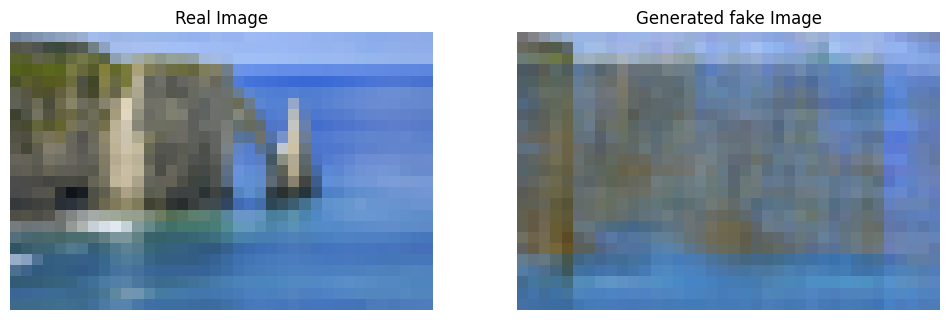

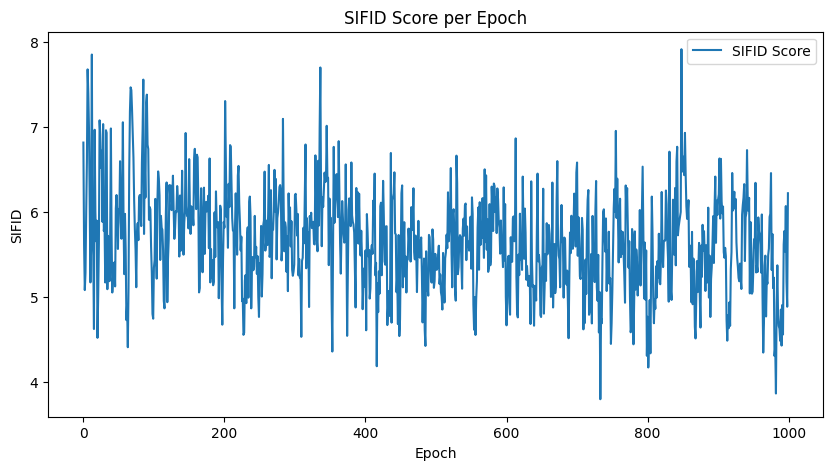

scale 1:[0/1000]
scale 1:[25/1000]
scale 1:[50/1000]
scale 1:[75/1000]
scale 1:[100/1000]
scale 1:[125/1000]
scale 1:[150/1000]
scale 1:[175/1000]
scale 1:[200/1000]
scale 1:[225/1000]
scale 1:[250/1000]
scale 1:[275/1000]
scale 1:[300/1000]
scale 1:[325/1000]
scale 1:[350/1000]
scale 1:[375/1000]
scale 1:[400/1000]
scale 1:[425/1000]
scale 1:[450/1000]
scale 1:[475/1000]
scale 1:[500/1000]
scale 1:[525/1000]
scale 1:[550/1000]
scale 1:[575/1000]
scale 1:[600/1000]
scale 1:[625/1000]
scale 1:[650/1000]
scale 1:[675/1000]
scale 1:[700/1000]
scale 1:[725/1000]
scale 1:[750/1000]
scale 1:[775/1000]
scale 1:[800/1000]
scale 1:[825/1000]
scale 1:[850/1000]
scale 1:[875/1000]
scale 1:[900/1000]
scale 1:[925/1000]
scale 1:[950/1000]
scale 1:[975/1000]
scale 1:[999/1000]


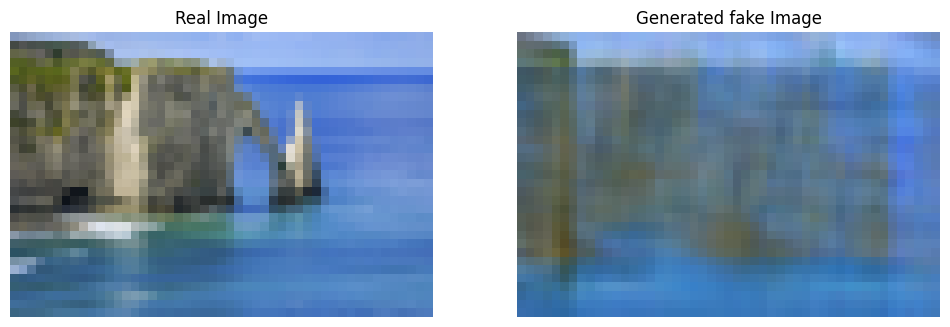

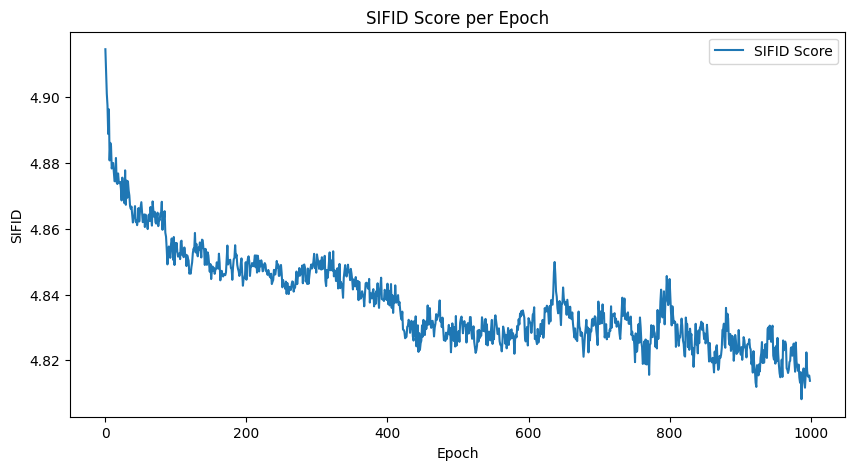

scale 2:[0/1000]
scale 2:[25/1000]
scale 2:[50/1000]
scale 2:[75/1000]
scale 2:[100/1000]
scale 2:[125/1000]
scale 2:[150/1000]
scale 2:[175/1000]
scale 2:[200/1000]
scale 2:[225/1000]
scale 2:[250/1000]
scale 2:[275/1000]
scale 2:[300/1000]
scale 2:[325/1000]
scale 2:[350/1000]
scale 2:[375/1000]
scale 2:[400/1000]
scale 2:[425/1000]
scale 2:[450/1000]
scale 2:[475/1000]
scale 2:[500/1000]
scale 2:[525/1000]
scale 2:[550/1000]
scale 2:[575/1000]
scale 2:[600/1000]
scale 2:[625/1000]
scale 2:[650/1000]
scale 2:[675/1000]
scale 2:[700/1000]
scale 2:[725/1000]
scale 2:[750/1000]
scale 2:[775/1000]
scale 2:[800/1000]
scale 2:[825/1000]
scale 2:[850/1000]
scale 2:[875/1000]
scale 2:[900/1000]
scale 2:[925/1000]
scale 2:[950/1000]
scale 2:[975/1000]
scale 2:[999/1000]


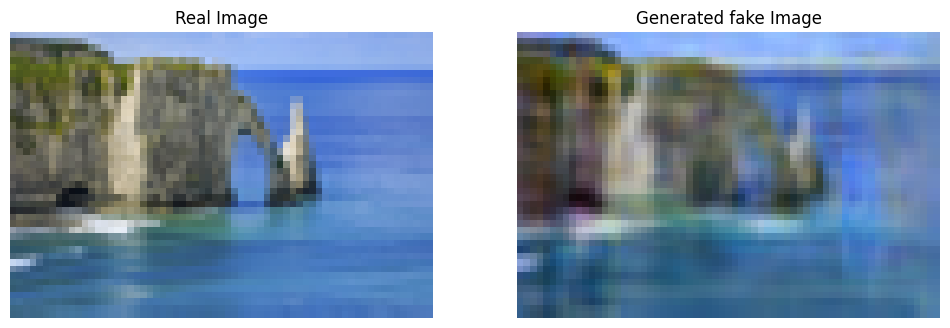

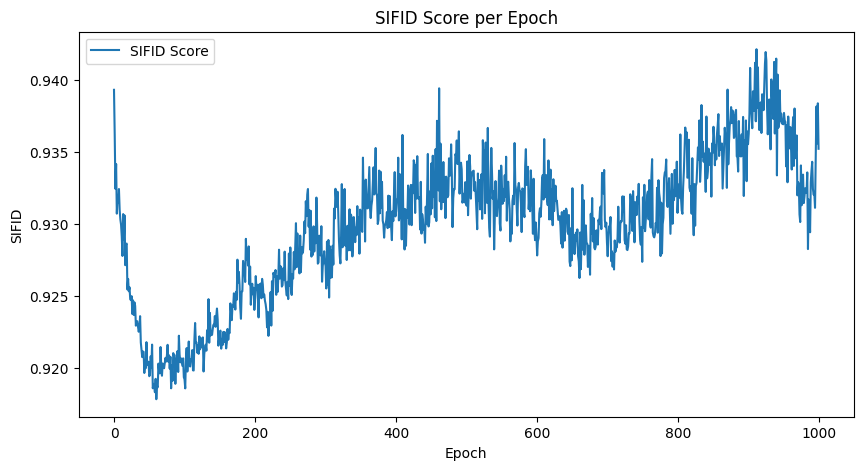

scale 3:[0/1000]
scale 3:[25/1000]
scale 3:[50/1000]
scale 3:[75/1000]
scale 3:[100/1000]
scale 3:[125/1000]
scale 3:[150/1000]
scale 3:[175/1000]
scale 3:[200/1000]
scale 3:[225/1000]
scale 3:[250/1000]
scale 3:[275/1000]
scale 3:[300/1000]
scale 3:[325/1000]
scale 3:[350/1000]
scale 3:[375/1000]
scale 3:[400/1000]
scale 3:[425/1000]
scale 3:[450/1000]
scale 3:[475/1000]
scale 3:[500/1000]
scale 3:[525/1000]
scale 3:[550/1000]
scale 3:[575/1000]
scale 3:[600/1000]
scale 3:[625/1000]
scale 3:[650/1000]
scale 3:[675/1000]
scale 3:[700/1000]
scale 3:[725/1000]
scale 3:[750/1000]
scale 3:[775/1000]
scale 3:[800/1000]
scale 3:[825/1000]
scale 3:[850/1000]
scale 3:[875/1000]
scale 3:[900/1000]
scale 3:[925/1000]
scale 3:[950/1000]
scale 3:[975/1000]
scale 3:[999/1000]


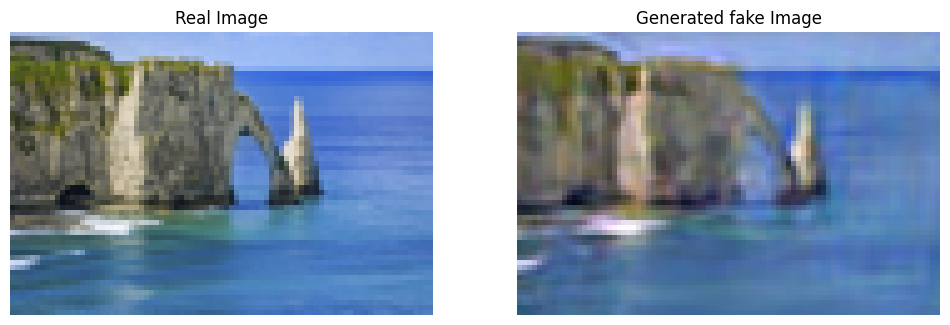

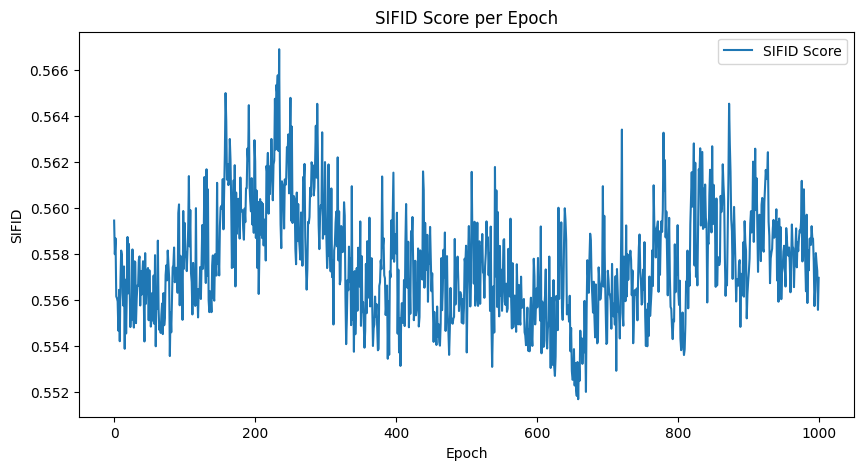

scale 4:[0/1000]
scale 4:[25/1000]
scale 4:[50/1000]
scale 4:[75/1000]
scale 4:[100/1000]
scale 4:[125/1000]
scale 4:[150/1000]
scale 4:[175/1000]
scale 4:[200/1000]
scale 4:[225/1000]
scale 4:[250/1000]
scale 4:[275/1000]
scale 4:[300/1000]
scale 4:[325/1000]
scale 4:[350/1000]
scale 4:[375/1000]
scale 4:[400/1000]
scale 4:[425/1000]
scale 4:[450/1000]
scale 4:[475/1000]
scale 4:[500/1000]
scale 4:[525/1000]
scale 4:[550/1000]
scale 4:[575/1000]
scale 4:[600/1000]
scale 4:[625/1000]
scale 4:[650/1000]
scale 4:[675/1000]
scale 4:[700/1000]
scale 4:[725/1000]
scale 4:[750/1000]
scale 4:[775/1000]
scale 4:[800/1000]
scale 4:[825/1000]
scale 4:[850/1000]
scale 4:[875/1000]
scale 4:[900/1000]
scale 4:[925/1000]
scale 4:[950/1000]
scale 4:[975/1000]
scale 4:[999/1000]


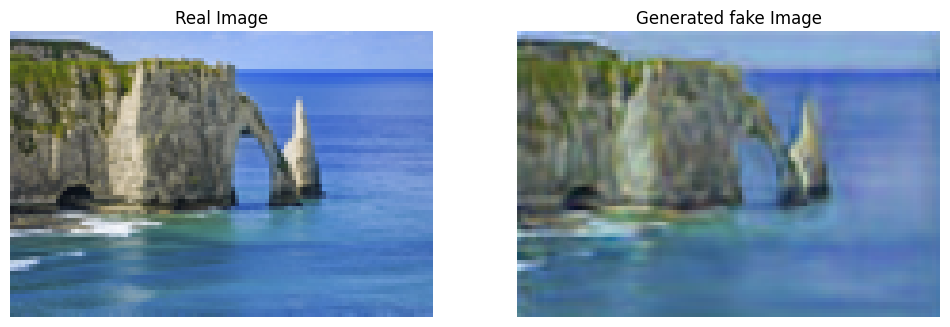

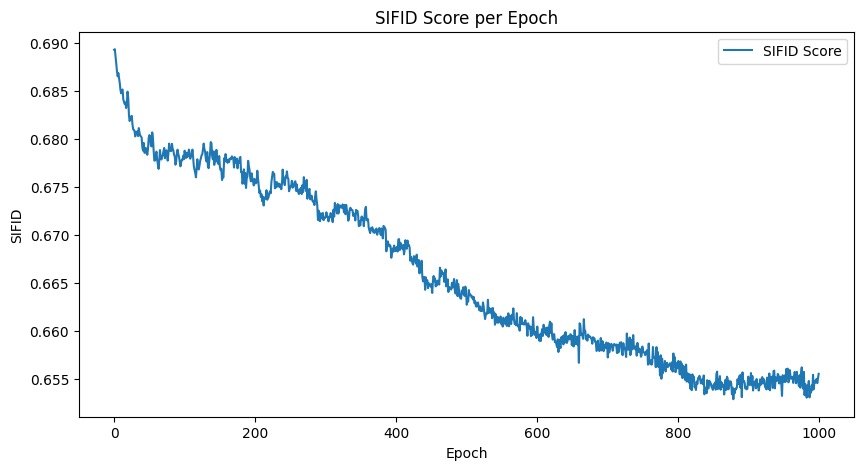

scale 5:[0/1000]
scale 5:[25/1000]
scale 5:[50/1000]
scale 5:[75/1000]
scale 5:[100/1000]
scale 5:[125/1000]
scale 5:[150/1000]
scale 5:[175/1000]
scale 5:[200/1000]
scale 5:[225/1000]
scale 5:[250/1000]
scale 5:[275/1000]
scale 5:[300/1000]
scale 5:[325/1000]
scale 5:[350/1000]
scale 5:[375/1000]
scale 5:[400/1000]
scale 5:[425/1000]
scale 5:[450/1000]
scale 5:[475/1000]
scale 5:[500/1000]
scale 5:[525/1000]
scale 5:[550/1000]
scale 5:[575/1000]
scale 5:[600/1000]
scale 5:[625/1000]
scale 5:[650/1000]
scale 5:[675/1000]
scale 5:[700/1000]
scale 5:[725/1000]
scale 5:[750/1000]
scale 5:[775/1000]
scale 5:[800/1000]
scale 5:[825/1000]
scale 5:[850/1000]
scale 5:[875/1000]
scale 5:[900/1000]
scale 5:[925/1000]
scale 5:[950/1000]
scale 5:[975/1000]
scale 5:[999/1000]


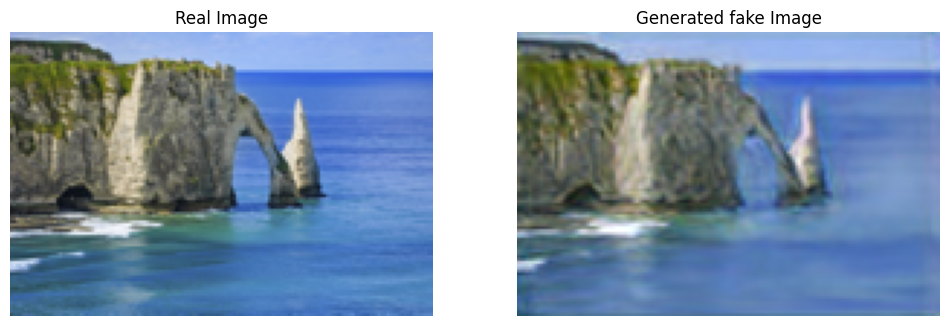

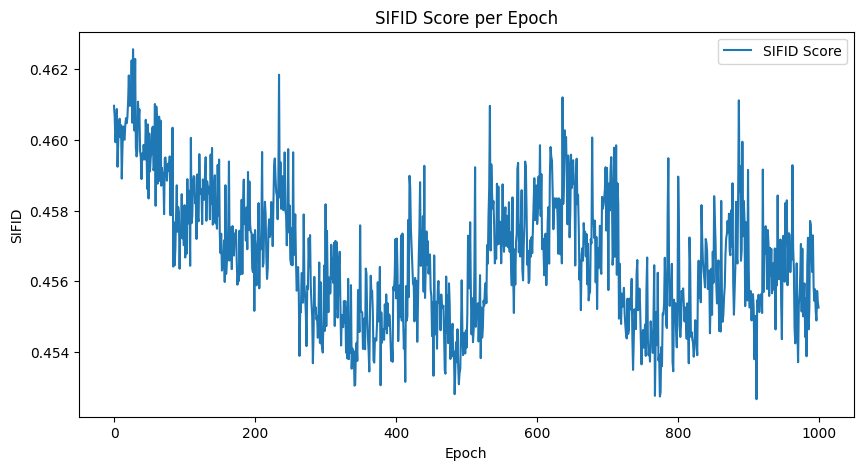

scale 6:[0/1000]
scale 6:[25/1000]
scale 6:[50/1000]
scale 6:[75/1000]
scale 6:[100/1000]
scale 6:[125/1000]
scale 6:[150/1000]
scale 6:[175/1000]
scale 6:[200/1000]
scale 6:[225/1000]
scale 6:[250/1000]
scale 6:[275/1000]
scale 6:[300/1000]
scale 6:[325/1000]
scale 6:[350/1000]
scale 6:[375/1000]
scale 6:[400/1000]
scale 6:[425/1000]
scale 6:[450/1000]
scale 6:[475/1000]
scale 6:[500/1000]
scale 6:[525/1000]
scale 6:[550/1000]
scale 6:[575/1000]
scale 6:[600/1000]
scale 6:[625/1000]
scale 6:[650/1000]
scale 6:[675/1000]
scale 6:[700/1000]
scale 6:[725/1000]
scale 6:[750/1000]
scale 6:[775/1000]
scale 6:[800/1000]
scale 6:[825/1000]
scale 6:[850/1000]
scale 6:[875/1000]
scale 6:[900/1000]
scale 6:[925/1000]
scale 6:[950/1000]
scale 6:[975/1000]
scale 6:[999/1000]


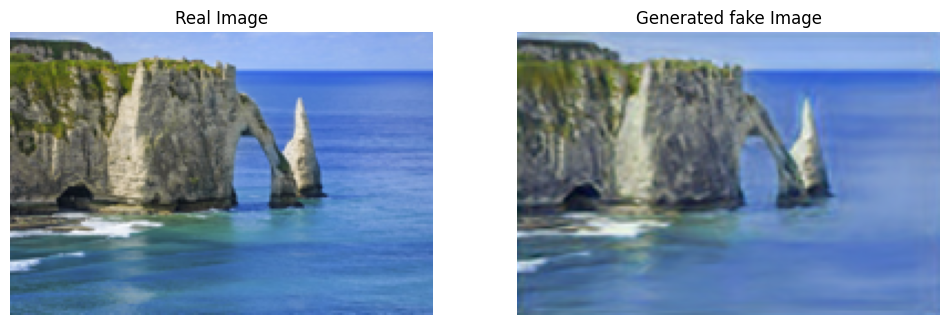

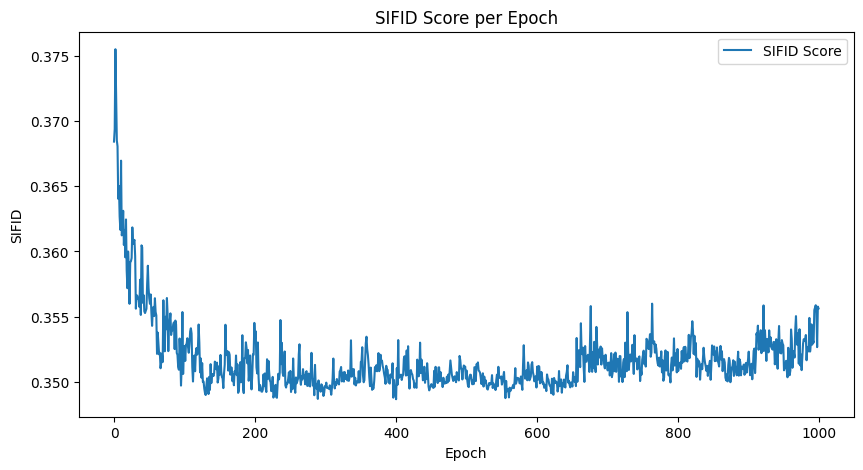

scale 7:[0/1000]
scale 7:[25/1000]
scale 7:[50/1000]
scale 7:[75/1000]
scale 7:[100/1000]
scale 7:[125/1000]
scale 7:[150/1000]
scale 7:[175/1000]
scale 7:[200/1000]
scale 7:[225/1000]
scale 7:[250/1000]
scale 7:[275/1000]
scale 7:[300/1000]
scale 7:[325/1000]
scale 7:[350/1000]
scale 7:[375/1000]
scale 7:[400/1000]
scale 7:[425/1000]
scale 7:[450/1000]
scale 7:[475/1000]
scale 7:[500/1000]
scale 7:[525/1000]
scale 7:[550/1000]
scale 7:[575/1000]
scale 7:[600/1000]
scale 7:[625/1000]
scale 7:[650/1000]
scale 7:[675/1000]
scale 7:[700/1000]
scale 7:[725/1000]
scale 7:[750/1000]
scale 7:[775/1000]
scale 7:[800/1000]
scale 7:[825/1000]
scale 7:[850/1000]
scale 7:[875/1000]
scale 7:[900/1000]
scale 7:[925/1000]
scale 7:[950/1000]
scale 7:[975/1000]
scale 7:[999/1000]


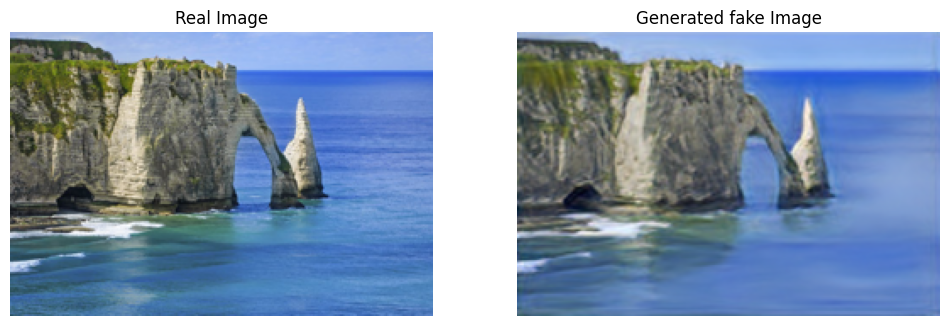

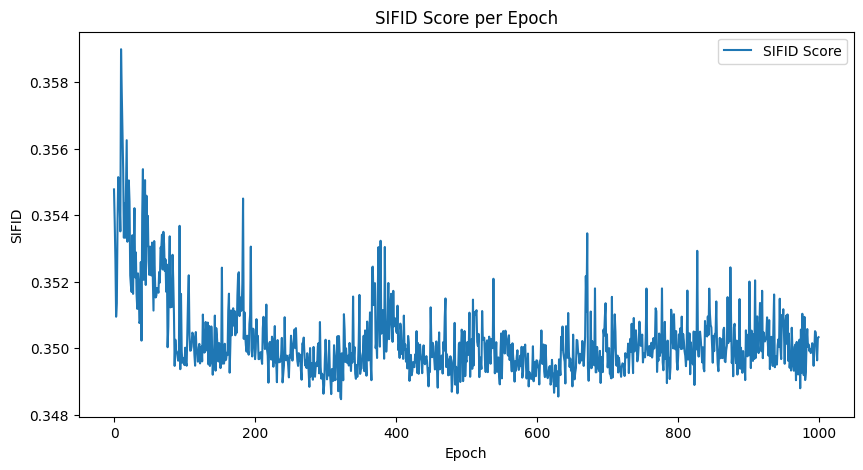

In [16]:

# Step 1: Get the command-line arguments or configuration settings
args = get_arguments()
opt = args

# Step 2: Set the name of the input image
opt.input_name = 'etretat.jpg'  # You can change this to the desired input image name

# Step 3: Finalize the configuration settings
opt = post_config(opt)

# Step 4: Initialize lists to store models, latent vectors, real images, and noise amplification factors
Gs = []         # List to store the generator networks for each scale
Zs = []         # List to store the latent vectors for each scale
reals = []      # List to store the real images for each scale
NoiseAmp = []   # List to store the noise amplification factors for each scale

# Step 5: Generate the directory path to save the trained models
dir2save = generate_dir2save(opt)

# Step 6: Check if the directory already exists
if os.path.exists(dir2save):
    print('Directory for Trained model already exists')  # If it exists, print a message
else:
    # If it does not exist, create the directory
    try:
        os.makedirs(dir2save)
    except OSError:
        pass  # If there's an error in creating the directory, just pass

# Step 7: Read and preprocess the input image
real = read_image(opt)

# Step 8: Adjust the scales of the image according to the configuration settings
adjust_scales2image(real, opt)


# Step 9: Train the model using the configurations and initialized lists
train(opt, Gs, Zs, reals, NoiseAmp)



In [17]:
!zip -r TrainedModels.zip TrainedModels
from google.colab import files
files.download("TrainedModels.zip")


  adding: TrainedModels/ (stored 0%)
  adding: TrainedModels/etretat/ (stored 0%)
  adding: TrainedModels/etretat/scale_factor=0.750000,alpha=10/ (stored 0%)
  adding: TrainedModels/etretat/scale_factor=0.750000,alpha=10/7/ (stored 0%)
  adding: TrainedModels/etretat/scale_factor=0.750000,alpha=10/7/netD.pth (deflated 8%)
  adding: TrainedModels/etretat/scale_factor=0.750000,alpha=10/7/G(z_opt).png (deflated 0%)
  adding: TrainedModels/etretat/scale_factor=0.750000,alpha=10/7/fake_sample.png (deflated 0%)
  adding: TrainedModels/etretat/scale_factor=0.750000,alpha=10/7/real_scale.png (deflated 0%)
  adding: TrainedModels/etretat/scale_factor=0.750000,alpha=10/7/z_opt.pth (deflated 100%)
  adding: TrainedModels/etretat/scale_factor=0.750000,alpha=10/7/netG.pth (deflated 8%)
  adding: TrainedModels/etretat/scale_factor=0.750000,alpha=10/reals.pth (deflated 34%)
  adding: TrainedModels/etretat/scale_factor=0.750000,alpha=10/0/ (stored 0%)
  adding: TrainedModels/etretat/scale_factor=0.750

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Generating image samples from noise input**

In [19]:
path = "/content/TrainedModels/etretat/scale_factor=0.750000,alpha=10/"
Gs = torch.load(path+"Gs.pth", map_location=torch.device('cpu'),weights_only=False)
Zs = torch.load(path+'Zs.pth', map_location=torch.device('cpu'),weights_only=False)
reals = torch.load(path+'reals.pth', map_location=torch.device('cpu'),weights_only=False)
NoiseAmp = torch.load(path+'NoiseAmp.pth', map_location=torch.device('cpu'),weights_only=False)

In [20]:
def GenerateSamples(Gs, Zs, reals, NoiseAmp, n_samples=10):

    for n, (G, Z_opt, real, noise_amp) in enumerate(zip(Gs, Zs, reals, NoiseAmp)):

        pad = nn.ZeroPad2d(5)
        _, _, nzx, nzy = real.shape

        if n == 0:
            z = torch.randn(n_samples,1,nzx,nzy) * noise_amp
            z = z.expand(n_samples,3,z.shape[2],z.shape[3])
            y = torch.full(z.shape, 0.)

        else:
            z = torch.randn(n_samples,3,nzx,nzy) * noise_amp
            n1, n2 = round(y.shape[2]/0.75), round(y.shape[3]/0.75)
            y = transforms.Resize((n1, n2))(y)
            y = y[:,:,:nzx, :nzy]

        x = pad(z + y)
        y = G(x, y)

    # denormalization
    batch = (y + 1 ) / 2
    batch = batch.clamp(0,1)

    # save in Output dir
    for i in range(n_samples):
        img = transforms.ToPILImage()(batch[i])
        img.save(f"Sample_{i+1}.png")

    return y

In [21]:
def show(img_t):
    """
    img_t : tensor of shape (3,h,w)
    """
    img = (img_t + 1) / 2
    img = img.clamp(0,1)
    img = transforms.ToPILImage()(img)
    plt.imshow(img)
    plt.show()

In [22]:
out = GenerateSamples(Gs, Zs, reals, NoiseAmp, n_samples=5)

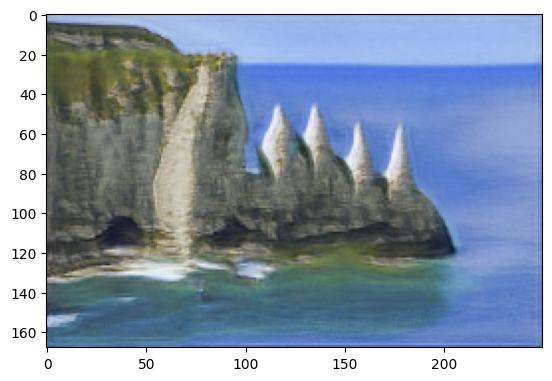

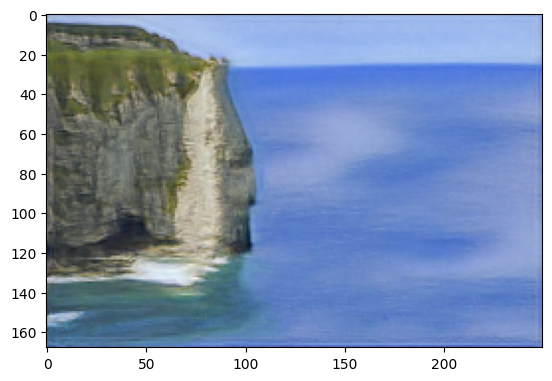

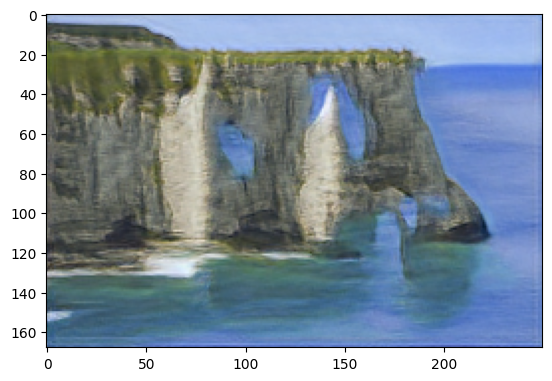

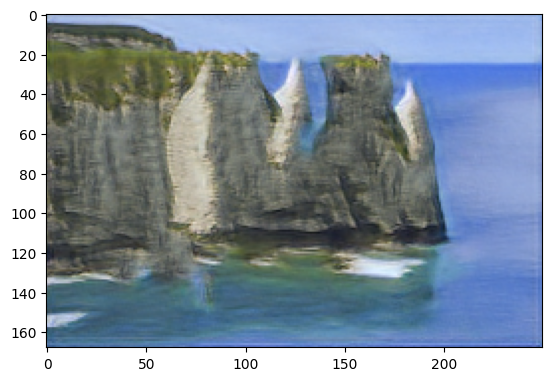

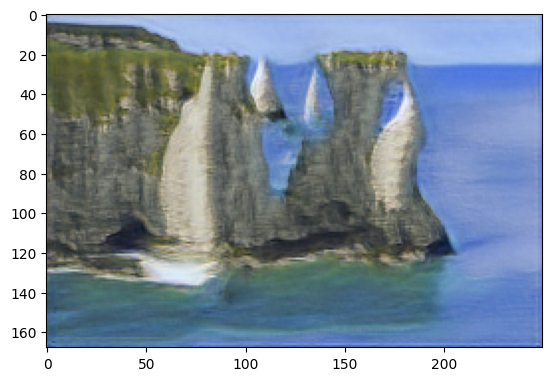

In [23]:
for i in range(5):
  show(out[i])

# **2- Changing the discriminator:**

## **2.1- Loss 1 : Distance of flechet as discriminator**

### New discriminator

In [24]:
def extract_patches(image, patch_size):
    '''
    extracts all the patchs from a given image with the given size window
    returns a numpy array of shape (window_area*number channels,number_patchs)
    with number_patchs is equal to (height - window_size/2)*(width-window_size/2)
    each pathc is represented by a column
    '''
    # Extract patches using sklearn's extract_patches_2d
    patches = nn.Unfold(kernel_size=patch_size)(image)
    return patches

def compute_mean_cov(patches):
    '''
    computes the mean and covariance of the patches
    '''
    # Step 1: Remove the batch dimension
    patches = patches.squeeze(0)

    # Step 2: Compute the mean of each row (feature)
    mean = patches.mean(dim=1, keepdim=True)

    # Step 3: Center the data by subtracting the mean
    centered_data = patches - mean  # Shape (12, 16)

    # Step 4: Compute the covariance matrix
    cov_matrix = (centered_data @ centered_data.T) / (patches.shape[1] - 1)
    return mean,cov_matrix



def sqrtm(matrix):
    """
    Computes the square root of a positive definite matrix using eigenvalue decomposition.
    Args:
        matrix (torch.Tensor): The input matrix (positive definite).
    Returns:
        torch.Tensor: The square root of the input matrix.
    """
    # Compute the eigenvalues and eigenvectors
    eigenvalues_, eigenvectors = torch.linalg.eigh(matrix)
    eigenvalues = torch.zeros_like(eigenvalues_)
    eigenvalues[eigenvalues_<0] = 0
    eigenvalues[eigenvalues_>0] = eigenvalues_[eigenvalues_>0]
    #print(eigenvalues,eigenvalues_)
    # Compute the square root of the eigenvalues
    sqrt_eigenvalues = torch.sqrt(eigenvalues)


    # Construct the square root matrix using eigenvectors and square root of eigenvalues
    sqrt_matrix = eigenvectors @ torch.diag(sqrt_eigenvalues) @ eigenvectors.T

    return sqrt_matrix

def compute_flechet_distance (mu1,sigma1,mu2,sigma2,eps=1e-10):
    assert mu1.shape == mu2.shape, 'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, 'Training and test covariances have different dimensions'

    diff = mu1 - mu2
    covmean = sqrtm(sigma1@sigma2)
    if not torch.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = sqrtm((sigma1 + offset)@(sigma2 + offset).T)

    #print(covmean.sum())
    tr_covmean = torch.trace(covmean)

    #return (diff.T@diff + torch.trace(sigma1) +
        #    torch.trace(sigma2) - 2 * tr_covmean)
    return (diff.T@diff + torch.norm((sigma1-sigma2)**2) )


def compute_loss_1(real,fake,window_size):
    '''
    uses the box filtering techinque to compute the local averages and the local covariance of the patchs.
    returns the frechet distance between the two averages and covariances.
    '''
    patch_real = extract_patches(real,window_size)
    mean_real,sigma_real = compute_mean_cov(patch_real)


    patch_fake = extract_patches(fake,window_size)
    mean_fake,sigma_fake = compute_mean_cov(patch_fake)

    loss_1 = compute_flechet_distance(mean_real,sigma_real,mean_fake,sigma_fake)
    return loss_1

### New Training

In [25]:
def update_generator_with_new_D(netG,window_size, real, fake, optimizerG, z_opt, z_prev, alpha, opt):
    netG.zero_grad()
    window_shape = (window_size,window_size)
    # Forward pass through discriminator
    #print(f"here what we are dealing with : real type, fake type, real shape ,fake shape {type(real),type(fake),real.shape,fake.shape}")
    errG = compute_loss_1(real,fake,window_shape)
    #errG = -output.mean()  # Calculate the generator loss
    errG.backward()  # Backpropagate the generator loss

    rec_loss = 0
    if alpha != 0:
        loss = nn.MSELoss()
        Z_opt = opt.noise_amp * z_opt+ z_prev
        rec_loss = alpha * loss(netG(Z_opt.detach(), z_prev.detach()), real)
        rec_loss.backward()  # Backpropagate the reconstruction loss
        rec_loss = rec_loss.detach()  # Detach to avoid inplace operation issues

    optimizerG.step()  # Update generator parameters

    return errG, rec_loss


In [26]:
def train_single_scale(netD, netG, reals, Gs, Zs, in_s, NoiseAmp, opt):
    torch.autograd.set_detect_anomaly(True)  # Enable anomaly detection for debugging
    real = reals[len(Gs)].float()  # Get the current real image at the current scale
    opt.nzx = real.shape[2]  # Set the size of the noise along x-dimension
    opt.nzy = real.shape[3]  # Set the size of the noise along y-dimension
    opt.receptive_field = opt.ker_size + ((opt.ker_size - 1) * (opt.num_layer - 1)) * opt.stride  # Calculate receptive field size
    pad_noise = int(((opt.ker_size - 1) * opt.num_layer) / 2)  # Calculate padding for noise
    pad_image = int(((opt.ker_size - 1) * opt.num_layer) / 2)  # Calculate padding for image
    m_noise = nn.ZeroPad2d(int(pad_noise))  # Create padding layer for noise
    m_image = nn.ZeroPad2d(int(pad_image))  # Create padding layer for image
    window_size=opt.receptive_field  # Set the window size to the receptive field size


    alpha = opt.alpha  # Set alpha parameter

    fixed_noise = generate_noise([opt.nc_z, opt.nzx, opt.nzy], device=opt.device).float()  # Generate fixed noise
    z_opt = torch.full(fixed_noise.shape, 0, device=opt.device).float()  # Initialize z_opt with zeros
    z_opt = m_noise(z_opt)  # Apply noise padding

    #optimizerD = optim.Adam(netD.parameters(), lr=opt.lr_d, betas=(opt.beta1, 0.999))  # Create optimizer for the discriminator
    optimizerG = optim.Adam(netG.parameters(), lr=opt.lr_g, betas=(opt.beta1, 0.999))  # Create optimizer for the generator
    #schedulerD = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizerD, milestones=[1600], gamma=opt.gamma)  # Learning rate scheduler for discriminator
    schedulerG = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizerG, milestones=[1600], gamma=opt.gamma)  # Learning rate scheduler for generator


    loss2plot = []  # List to store losses
    for epoch in range(opt.niter):
        if not Gs:  # If there are no previous scales
            z_opt = generate_noise([1, opt.nzx, opt.nzy], device=opt.device).float()  # Generate new noise
            z_opt = m_noise(z_opt.expand(1, 3, opt.nzx, opt.nzy))  # Expand and pad the noise
            noise_ = generate_noise([1, opt.nzx, opt.nzy], device=opt.device).float()  # Generate another noise
            noise_ = m_noise(noise_.expand(1, 3, opt.nzx, opt.nzy))  # Expand and pad the noise
        else:
            noise_ = generate_noise([opt.nc_z, opt.nzx, opt.nzy], device=opt.device).float()  # Generate new noise for the current scale
            noise_ = m_noise(noise_)  # Pad the noise

        if epoch == 0:  # At the start of training
            if not Gs:  # If there are no previous scales
                prev = torch.full([1, opt.nc_z, opt.nzx, opt.nzy], 0, device=opt.device).float()  # Initialize prev with zeros
                in_s = prev  # Set in_s to prev
                prev = m_image(prev)  # Apply image padding
                z_prev = torch.full([1, opt.nc_z, opt.nzx, opt.nzy], 0, device=opt.device).float()  # Initialize z_prev with zeros
                z_prev = m_noise(z_prev)  # Apply noise padding
                opt.noise_amp = 1  # Set noise amplitude
            else:  # If there are previous scales
                prev = draw_concat(Gs, Zs, reals, NoiseAmp, in_s, 'rand', m_noise, m_image, opt).float()  # Draw concatenated image with random noise
                prev = m_image(prev)  # Apply image padding
                z_prev = draw_concat(Gs, Zs, reals, NoiseAmp, in_s, 'rec', m_noise, m_image, opt).float()  # Draw concatenated image with reconstruction noise
                criterion = nn.MSELoss()  # Define Mean Squared Error loss
                RMSE = torch.sqrt(criterion(real, z_prev))  # Calculate Root Mean Squared Error between real and z_prev
                opt.noise_amp = opt.noise_amp_init * RMSE  # Adjust noise amplitude based on RMSE
                z_prev = m_image(z_prev)  # Apply image padding
        else:
            prev = draw_concat(Gs, Zs, reals, NoiseAmp, in_s, 'rand', m_noise, m_image, opt).float()  # Draw concatenated image with random noise
            prev = m_image(prev)  # Apply image padding

        if not Gs:
            noise = noise_
        else:
            noise = opt.noise_amp * noise_ + prev  # Combine noise and previous image

        fake = netG(noise.detach(), prev.float())  # Generate fake image using the generator

        # Update generator
        for j in range(opt.Gsteps):
            fake = netG(noise.detach(), prev.float())  # Generate fake image using the generator
            errG, rec_loss = update_generator_with_new_D(netG, window_size, real, fake, optimizerG, z_opt, z_prev, alpha, opt)  # Update generator

            loss2plot.append(errG.detach().item())

        if epoch % 25 == 0 or epoch == (opt.niter - 1):
            print('scale %d:[%d/%d]' % (len(Gs), epoch, opt.niter))  # Print progress

        if epoch % 500 == 0 or epoch == (opt.niter - 1):
            plt.imsave('%s/fake_sample.png' % (opt.outf), convert_image_np(fake.detach()), vmin=0, vmax=1)  # Save fake image
            plt.imsave('%s/G(z_opt).png' % (opt.outf), convert_image_np(netG(z_opt.detach(), z_prev.float()).detach()), vmin=0, vmax=1)  # Save generator output for z_opt
            torch.save(z_opt, '%s/z_opt.pth' % (opt.outf))  # Save z_opt

    # Display the real and fake images in the same row at the end of training each scale
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(convert_image_np(real), vmin=0, vmax=1)
    ax[0].set_title('Real Image')
    ax[0].axis('off')

    ax[1].imshow(convert_image_np(fake.detach()), vmin=0, vmax=1)
    ax[1].set_title('Fake Image')
    ax[1].axis('off')

    plt.show()

    # Plot SIFID scores
    plt.figure(figsize=(10, 5))
    plt.plot(loss2plot, label='frechet loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.title('loss Score per Epoch')
    plt.legend()
    plt.show()

    save_networks(netG, netD, z_opt, opt)  # Save the networks
    return loss2plot,z_opt, in_s, netG  # Return the optimal z, input scale, and generator


In [27]:
# @title
def train(opt, Gs, Zs, reals, NoiseAmp):
    # Read and preprocess the input image
    real_ = read_image(opt)
    in_s = 0  # Initialize the starting image
    scale_num = 0  # Initialize the scale level
    real = imresize(real_, opt.scale1, opt)  # Resize the input image to the first scale ## The input image will have max dim = 250 and will be resized accordingly
    reals = creat_reals_pyramid(real, reals, opt)  # Create a pyramid of resized images
    nfc_prev = 0  # Initialize the previous number of feature channels
    loss2plot = []
    while scale_num < opt.stop_scale + 1:
        # Update the number of feature channels based on the scale level
        opt.nfc = min(opt.nfc_init * pow(2, math.floor(scale_num / 4)), 128)
        opt.min_nfc = min(opt.min_nfc_init * pow(2, math.floor(scale_num / 4)), 128)

        # Generate directory to save the models
        opt.out_ = generate_dir2save(opt)
        opt.outf = f'{opt.out_}/{scale_num}'
        os.makedirs(opt.outf, exist_ok=True)  # Create the directory if it doesn't exist

        # Save the real image at the current scale
        plt.imsave(f'{opt.outf}/real_scale.png', convert_image_np(reals[scale_num]), vmin=0, vmax=1)

        # Initialize the models for the current scale
        D_curr, G_curr = init_models(opt)
        if nfc_prev == opt.nfc:
            # Load pre-trained weights if the number of feature channels hasn't changed
            G_curr.load_state_dict(torch.load(f'{opt.out_}/{scale_num-1}/netG.pth'))
            D_curr.load_state_dict(torch.load(f'{opt.out_}/{scale_num-1}/netD.pth'))

        # Train the models for the current scale
        loss_pot,z_curr, in_s, G_curr = train_single_scale(D_curr, G_curr, reals, Gs, Zs, in_s, NoiseAmp, opt)
        loss2plot.extend(loss_pot)

        # Set the models to evaluation mode and reset their gradients
        G_curr = reset_grads(G_curr, False)
        G_curr.eval()
        D_curr = reset_grads(D_curr, False)
        D_curr.eval()

        # Append the trained models and parameters to their respective lists
        Gs.append(G_curr)
        Zs.append(z_curr)
        NoiseAmp.append(opt.noise_amp)

        # Save the current state of the training process
        torch.save(Zs, f'{opt.out_}/Zs.pth')
        torch.save(Gs, f'{opt.out_}/Gs.pth')
        torch.save(reals, f'{opt.out_}/reals.pth')
        torch.save(NoiseAmp, f'{opt.out_}/NoiseAmp.pth')

        # Move to the next scale
        scale_num += 1
        nfc_prev = opt.nfc
        del D_curr, G_curr  # Free up memory

    plt.figure(figsize=(10, 5))
    plt.plot(loss2plot, label='flechet loss over all scales')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.title('loss Score ')
    plt.legend()
    plt.show()
    return


### Defining hyperparameters

In [28]:
# @title
class DotDict(dict):
    """ Dictionary with dot notation access to attributes. """
    def __getattr__(self, attr):
        return self.get(attr)

    def __setattr__(self, attr, value):
        self[attr] = value

    def __delattr__(self, attr):
        del self[attr]


def get_arguments():
    args = DotDict()
    args.not_cuda = False
    args.netG = ''  #Path to a pre-trained generator network, if any. Default is an empty string.
    args.netD = ''  #Path to a pre-trained discriminator network, if any. Default is an empty string.
    args.manualSeed = None   #Seed for random number generation.
    args.nc_z = 3    #Number of channels in the noise input. Default is 3.
    args.nc_im = 3  #Number of channels in the input image. Default is 3.
    args.out = 'Output'   #Directory to save the output results.
    args.nfc = 32      #Number of feature channels in the first layer of the generator. Default is 32.
    args.min_nfc = 32   #Minimum number of feature channels in the generator. Default is 32.
    args.ker_size = 3  #Kernel size for the convolutional layers. Default is 3.
    args.num_layer = 5   #Number of layers in the generator and discriminator networks. Default is 5.
    args.stride = 1     #Stride for the convolutional layers. Default is 1.
    args.padd_size = 0    #Padding size for the convolutional layers. Default is 0.
    args.scale_factor = 0.75   #Scale factor for creating image pyramids. Default is 0.75.
    args.noise_amp = 0.1   #Amplitude of the noise added at each scale. Default is 0.1.
    args.min_size = 25   #Minimum size of the images in the pyramid. Default is 25.
    args.max_size = 250   #Maximum size of the images in the pyramid. Default is 250
    args.niter = 1000  #Number of iterations for training at each scale. Default is 10.
    args.gamma = 0.1   #Factor for learning rate decay. Default is 0.1.
    args.lr_g = 0.0005    #Learning rate for the generator. Default is 0.0005.
    args.lr_d = 0.0005    #Learning rate for the discriminator. Default is 0.0005.
    args.beta1 = 0.5    #Beta1 parameter for Adam optimizer. Default is 0.5.
    args.Gsteps = 3    #Number of steps to update the generator in each iteration. Default is 3.
    args.Dsteps = 3    #Number of steps to update the discriminator in each iteration. Default is 3.
    args.lambda_grad = 0.1    #Gradient penalty coefficient for WGAN-GP. Default is 0.1.
    args.alpha = 10     # Weight for the reconstruction loss. Default is 10
    args.input_dir = 'Input'  #Directory containing the input images.
    args.input_name = ''   #Name of the input image file.
    args.mode = 'train' #Mode of operation

    return args

def post_config(opt):
    """ adjusts some of the configuration parameters based on the initial settings and performs additional setup"""
    opt.device = torch.device("cpu" if opt.not_cuda or not torch.cuda.is_available() else "cuda")
    opt.niter_init = opt.niter
    opt.noise_amp_init = opt.noise_amp
    opt.nfc_init = opt.nfc
    opt.min_nfc_init = opt.min_nfc
    opt.scale_factor_init = opt.scale_factor
    opt.out_ = 'TrainedModels/%s/scale_factor=%f/' % (opt.input_name[:-4], opt.scale_factor)

    if opt.manualSeed is None:
        opt.manualSeed = random.randint(1, 10000)
    print("Random Seed: ", opt.manualSeed)
    random.seed(opt.manualSeed)
    torch.manual_seed(opt.manualSeed)
    if torch.cuda.is_available() and opt.not_cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")
    return opt

### Main
🚩 **NB**: You should have a file 'Input' in which there will be the input image and change its name in the variable 'opt.input_name' below

In [29]:
!rm -rf /content/TrainedModels


Random Seed:  4442
scale 0:[0/1000]
scale 0:[25/1000]
scale 0:[50/1000]
scale 0:[75/1000]
scale 0:[100/1000]
scale 0:[125/1000]
scale 0:[150/1000]
scale 0:[175/1000]
scale 0:[200/1000]
scale 0:[225/1000]
scale 0:[250/1000]
scale 0:[275/1000]
scale 0:[300/1000]
scale 0:[325/1000]
scale 0:[350/1000]
scale 0:[375/1000]
scale 0:[400/1000]
scale 0:[425/1000]
scale 0:[450/1000]
scale 0:[475/1000]
scale 0:[500/1000]
scale 0:[525/1000]
scale 0:[550/1000]
scale 0:[575/1000]
scale 0:[600/1000]
scale 0:[625/1000]
scale 0:[650/1000]
scale 0:[675/1000]
scale 0:[700/1000]
scale 0:[725/1000]
scale 0:[750/1000]
scale 0:[775/1000]
scale 0:[800/1000]
scale 0:[825/1000]
scale 0:[850/1000]
scale 0:[875/1000]
scale 0:[900/1000]
scale 0:[925/1000]
scale 0:[950/1000]
scale 0:[975/1000]
scale 0:[999/1000]


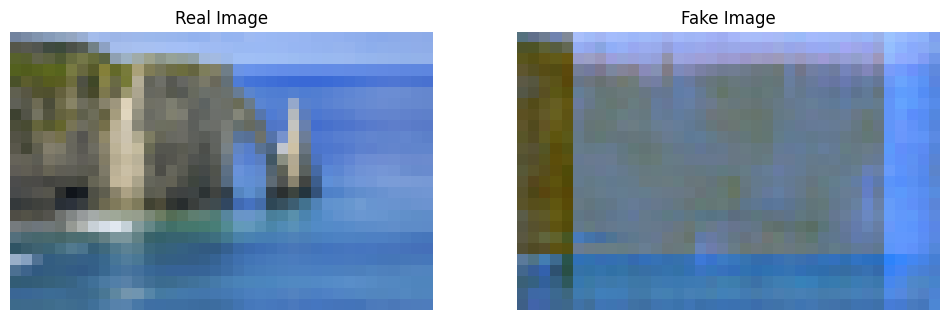

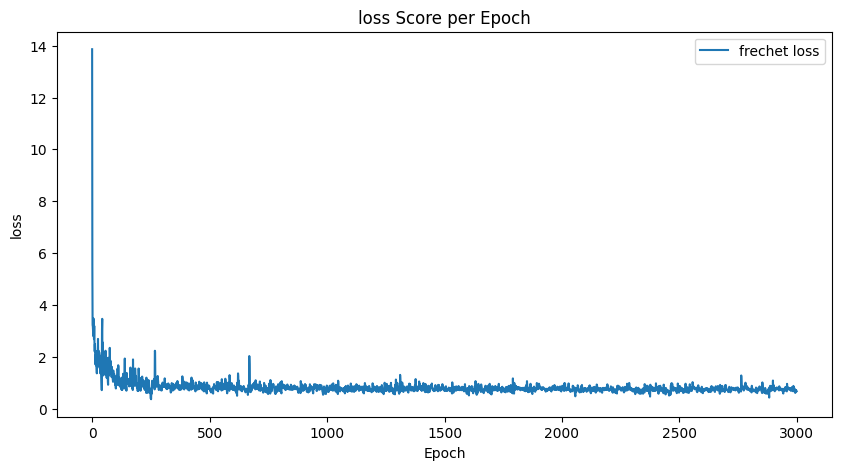

scale 1:[0/1000]
scale 1:[25/1000]
scale 1:[50/1000]
scale 1:[75/1000]
scale 1:[100/1000]
scale 1:[125/1000]
scale 1:[150/1000]
scale 1:[175/1000]
scale 1:[200/1000]
scale 1:[225/1000]
scale 1:[250/1000]
scale 1:[275/1000]
scale 1:[300/1000]
scale 1:[325/1000]
scale 1:[350/1000]
scale 1:[375/1000]
scale 1:[400/1000]
scale 1:[425/1000]
scale 1:[450/1000]
scale 1:[475/1000]
scale 1:[500/1000]
scale 1:[525/1000]
scale 1:[550/1000]
scale 1:[575/1000]
scale 1:[600/1000]
scale 1:[625/1000]
scale 1:[650/1000]
scale 1:[675/1000]
scale 1:[700/1000]
scale 1:[725/1000]
scale 1:[750/1000]
scale 1:[775/1000]
scale 1:[800/1000]
scale 1:[825/1000]
scale 1:[850/1000]
scale 1:[875/1000]
scale 1:[900/1000]
scale 1:[925/1000]
scale 1:[950/1000]
scale 1:[975/1000]
scale 1:[999/1000]


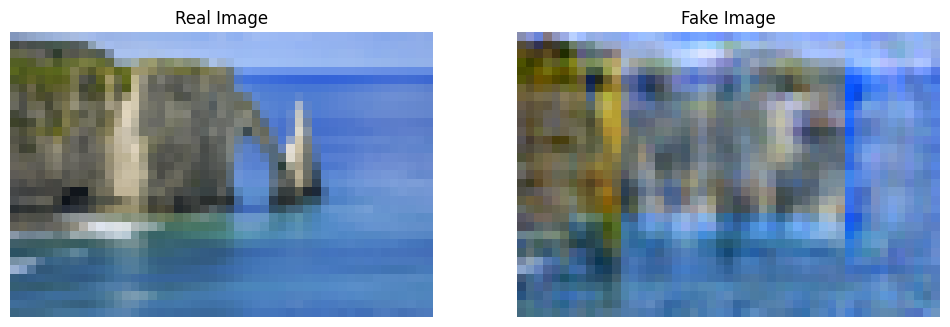

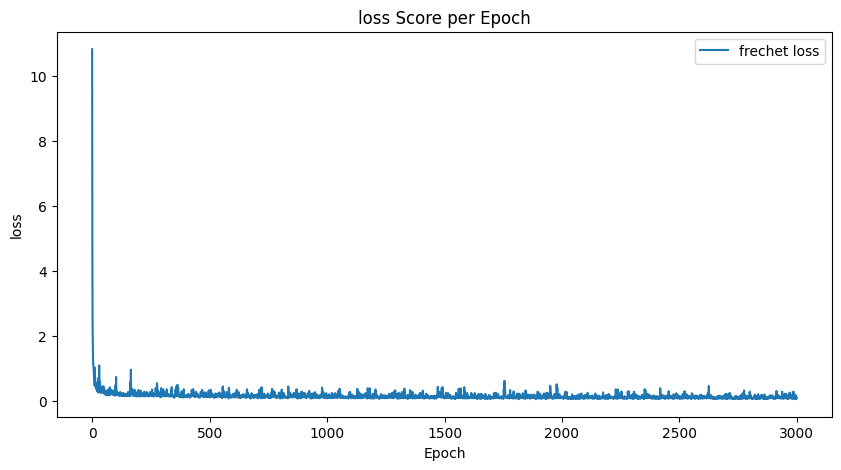

scale 2:[0/1000]
scale 2:[25/1000]
scale 2:[50/1000]
scale 2:[75/1000]
scale 2:[100/1000]
scale 2:[125/1000]
scale 2:[150/1000]
scale 2:[175/1000]
scale 2:[200/1000]
scale 2:[225/1000]
scale 2:[250/1000]
scale 2:[275/1000]
scale 2:[300/1000]
scale 2:[325/1000]
scale 2:[350/1000]
scale 2:[375/1000]
scale 2:[400/1000]
scale 2:[425/1000]
scale 2:[450/1000]
scale 2:[475/1000]
scale 2:[500/1000]
scale 2:[525/1000]
scale 2:[550/1000]
scale 2:[575/1000]
scale 2:[600/1000]
scale 2:[625/1000]
scale 2:[650/1000]
scale 2:[675/1000]
scale 2:[700/1000]
scale 2:[725/1000]
scale 2:[750/1000]
scale 2:[775/1000]
scale 2:[800/1000]
scale 2:[825/1000]
scale 2:[850/1000]
scale 2:[875/1000]
scale 2:[900/1000]
scale 2:[925/1000]
scale 2:[950/1000]
scale 2:[975/1000]
scale 2:[999/1000]


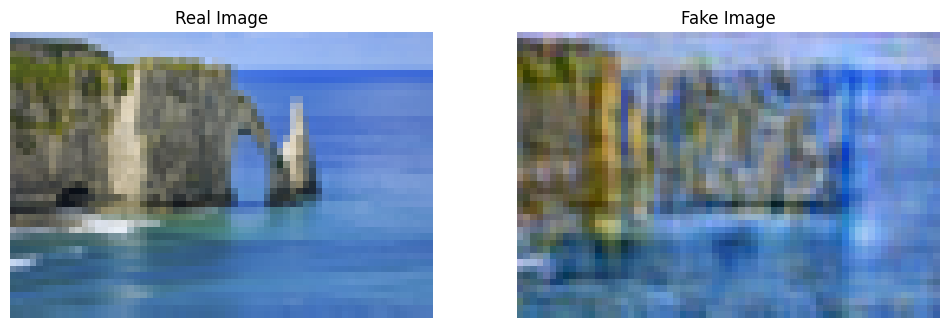

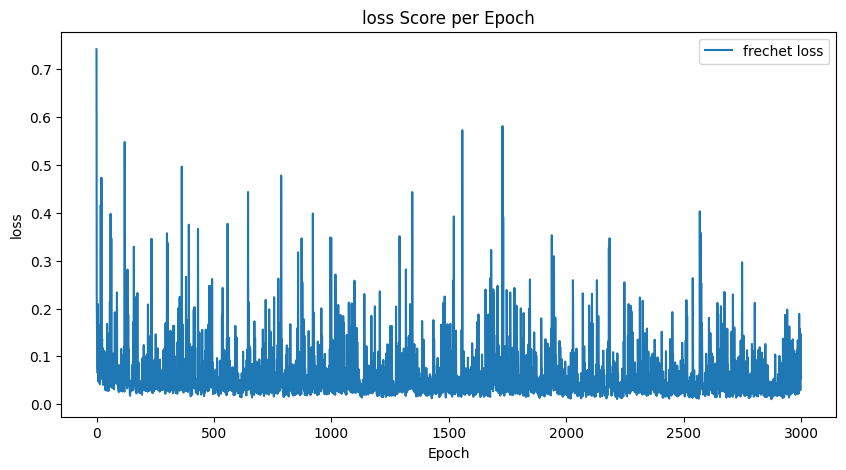

scale 3:[0/1000]
scale 3:[25/1000]
scale 3:[50/1000]
scale 3:[75/1000]
scale 3:[100/1000]
scale 3:[125/1000]
scale 3:[150/1000]
scale 3:[175/1000]
scale 3:[200/1000]
scale 3:[225/1000]
scale 3:[250/1000]
scale 3:[275/1000]
scale 3:[300/1000]
scale 3:[325/1000]
scale 3:[350/1000]
scale 3:[375/1000]
scale 3:[400/1000]
scale 3:[425/1000]
scale 3:[450/1000]
scale 3:[475/1000]
scale 3:[500/1000]
scale 3:[525/1000]
scale 3:[550/1000]
scale 3:[575/1000]
scale 3:[600/1000]
scale 3:[625/1000]
scale 3:[650/1000]
scale 3:[675/1000]
scale 3:[700/1000]
scale 3:[725/1000]
scale 3:[750/1000]
scale 3:[775/1000]
scale 3:[800/1000]
scale 3:[825/1000]
scale 3:[850/1000]
scale 3:[875/1000]
scale 3:[900/1000]
scale 3:[925/1000]
scale 3:[950/1000]
scale 3:[975/1000]
scale 3:[999/1000]


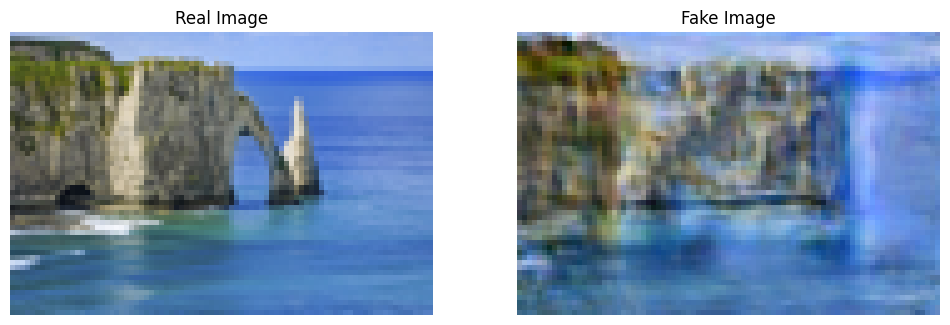

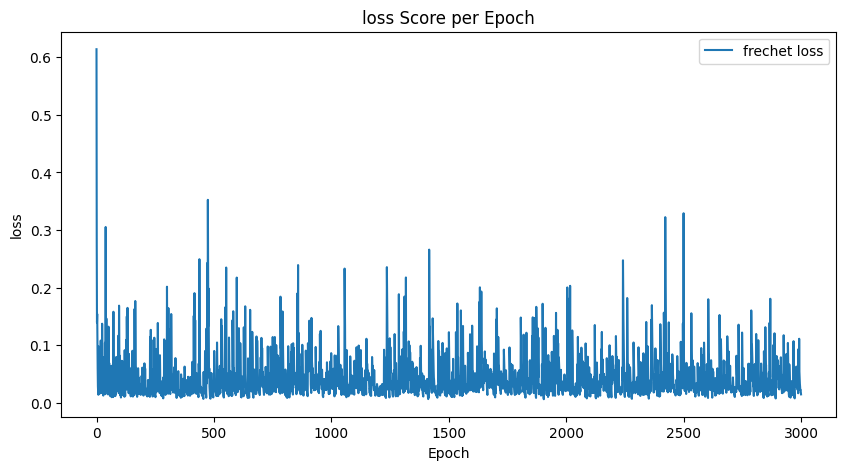

scale 4:[0/1000]
scale 4:[25/1000]
scale 4:[50/1000]
scale 4:[75/1000]
scale 4:[100/1000]
scale 4:[125/1000]
scale 4:[150/1000]
scale 4:[175/1000]
scale 4:[200/1000]
scale 4:[225/1000]
scale 4:[250/1000]
scale 4:[275/1000]
scale 4:[300/1000]
scale 4:[325/1000]
scale 4:[350/1000]
scale 4:[375/1000]
scale 4:[400/1000]
scale 4:[425/1000]
scale 4:[450/1000]
scale 4:[475/1000]
scale 4:[500/1000]
scale 4:[525/1000]
scale 4:[550/1000]
scale 4:[575/1000]
scale 4:[600/1000]
scale 4:[625/1000]
scale 4:[650/1000]
scale 4:[675/1000]
scale 4:[700/1000]
scale 4:[725/1000]
scale 4:[750/1000]
scale 4:[775/1000]
scale 4:[800/1000]
scale 4:[825/1000]
scale 4:[850/1000]
scale 4:[875/1000]
scale 4:[900/1000]
scale 4:[925/1000]
scale 4:[950/1000]
scale 4:[975/1000]
scale 4:[999/1000]


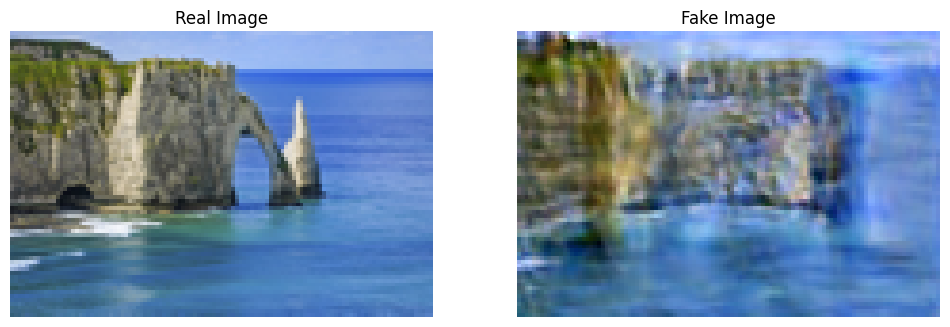

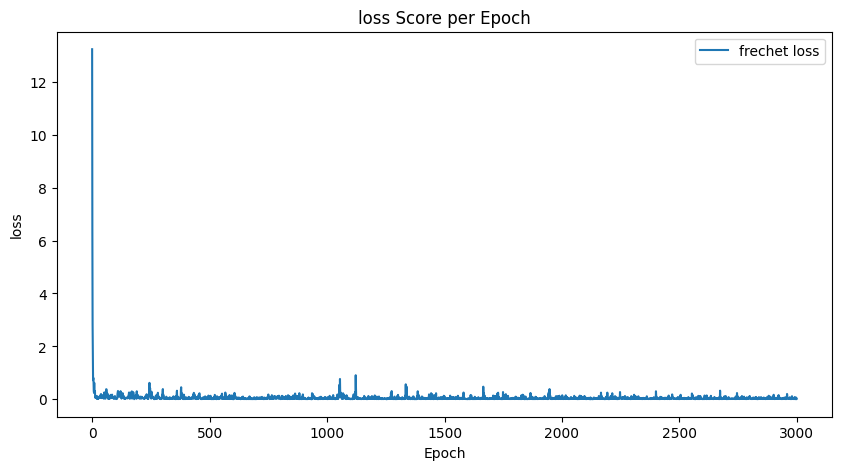

scale 5:[0/1000]
scale 5:[25/1000]
scale 5:[50/1000]
scale 5:[75/1000]
scale 5:[100/1000]
scale 5:[125/1000]
scale 5:[150/1000]
scale 5:[175/1000]
scale 5:[200/1000]
scale 5:[225/1000]
scale 5:[250/1000]
scale 5:[275/1000]
scale 5:[300/1000]
scale 5:[325/1000]
scale 5:[350/1000]
scale 5:[375/1000]
scale 5:[400/1000]
scale 5:[425/1000]
scale 5:[450/1000]
scale 5:[475/1000]
scale 5:[500/1000]
scale 5:[525/1000]
scale 5:[550/1000]
scale 5:[575/1000]
scale 5:[600/1000]
scale 5:[625/1000]
scale 5:[650/1000]
scale 5:[675/1000]
scale 5:[700/1000]
scale 5:[725/1000]
scale 5:[750/1000]
scale 5:[775/1000]
scale 5:[800/1000]
scale 5:[825/1000]
scale 5:[850/1000]
scale 5:[875/1000]
scale 5:[900/1000]
scale 5:[925/1000]
scale 5:[950/1000]
scale 5:[975/1000]
scale 5:[999/1000]


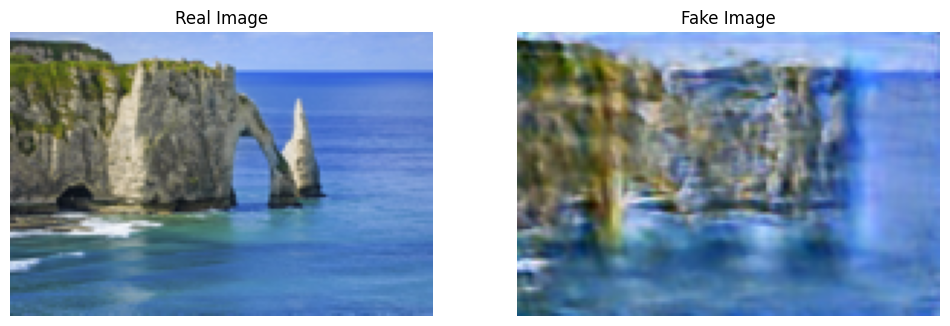

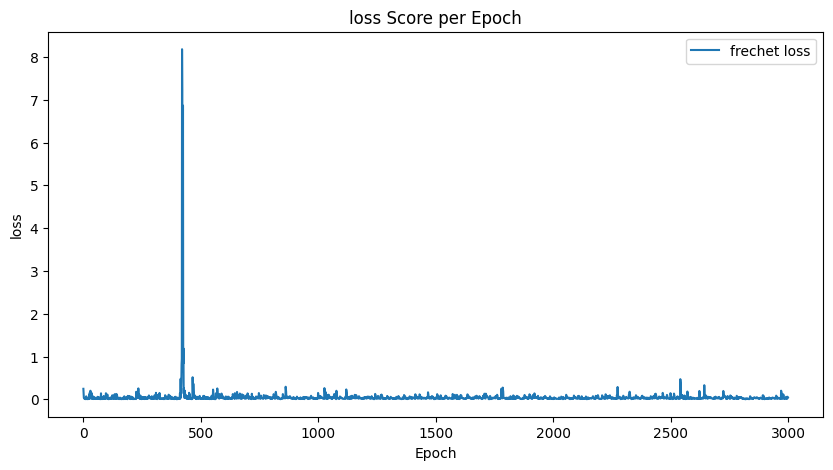

scale 6:[0/1000]
scale 6:[25/1000]
scale 6:[50/1000]
scale 6:[75/1000]
scale 6:[100/1000]
scale 6:[125/1000]
scale 6:[150/1000]
scale 6:[175/1000]
scale 6:[200/1000]
scale 6:[225/1000]
scale 6:[250/1000]
scale 6:[275/1000]
scale 6:[300/1000]
scale 6:[325/1000]
scale 6:[350/1000]
scale 6:[375/1000]
scale 6:[400/1000]
scale 6:[425/1000]
scale 6:[450/1000]
scale 6:[475/1000]
scale 6:[500/1000]
scale 6:[525/1000]
scale 6:[550/1000]
scale 6:[575/1000]
scale 6:[600/1000]
scale 6:[625/1000]
scale 6:[650/1000]
scale 6:[675/1000]
scale 6:[700/1000]
scale 6:[725/1000]
scale 6:[750/1000]
scale 6:[775/1000]
scale 6:[800/1000]
scale 6:[825/1000]
scale 6:[850/1000]
scale 6:[875/1000]
scale 6:[900/1000]
scale 6:[925/1000]
scale 6:[950/1000]
scale 6:[975/1000]
scale 6:[999/1000]


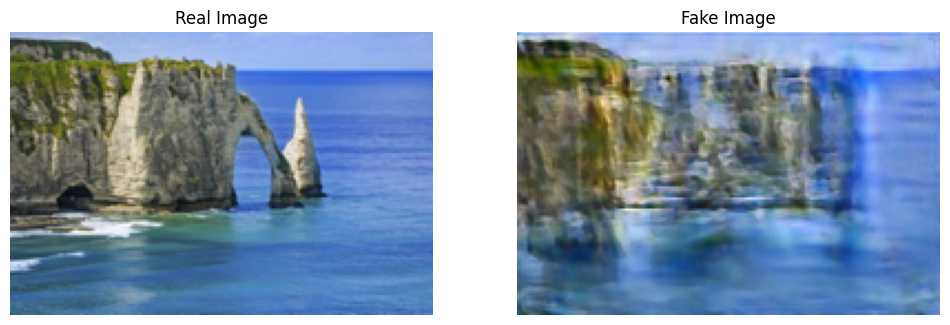

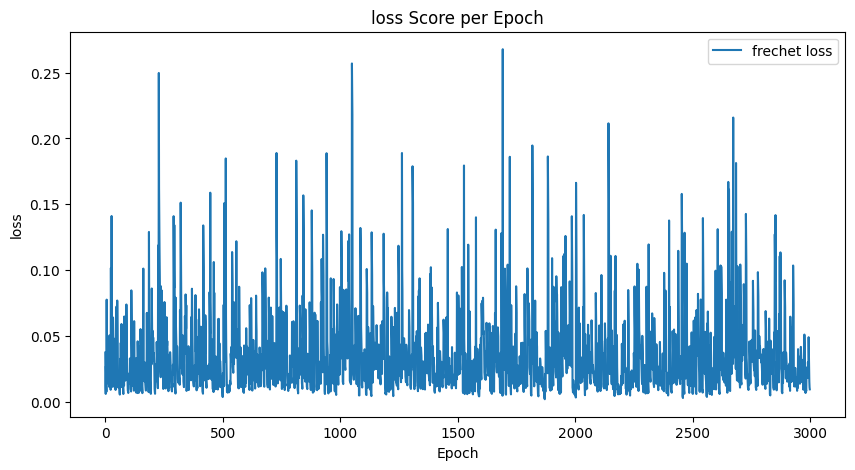

scale 7:[0/1000]
scale 7:[25/1000]
scale 7:[50/1000]
scale 7:[75/1000]
scale 7:[100/1000]
scale 7:[125/1000]
scale 7:[150/1000]
scale 7:[175/1000]
scale 7:[200/1000]
scale 7:[225/1000]
scale 7:[250/1000]
scale 7:[275/1000]
scale 7:[300/1000]
scale 7:[325/1000]
scale 7:[350/1000]
scale 7:[375/1000]
scale 7:[400/1000]
scale 7:[425/1000]
scale 7:[450/1000]
scale 7:[475/1000]
scale 7:[500/1000]
scale 7:[525/1000]
scale 7:[550/1000]
scale 7:[575/1000]
scale 7:[600/1000]
scale 7:[625/1000]
scale 7:[650/1000]
scale 7:[675/1000]
scale 7:[700/1000]
scale 7:[725/1000]
scale 7:[750/1000]
scale 7:[775/1000]
scale 7:[800/1000]
scale 7:[825/1000]
scale 7:[850/1000]
scale 7:[875/1000]
scale 7:[900/1000]
scale 7:[925/1000]
scale 7:[950/1000]
scale 7:[975/1000]
scale 7:[999/1000]


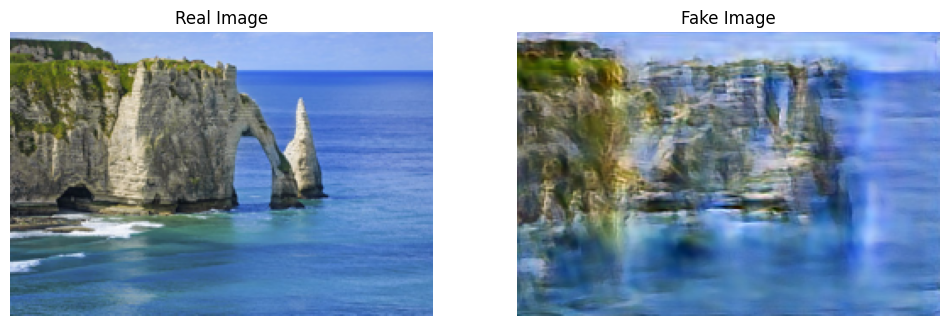

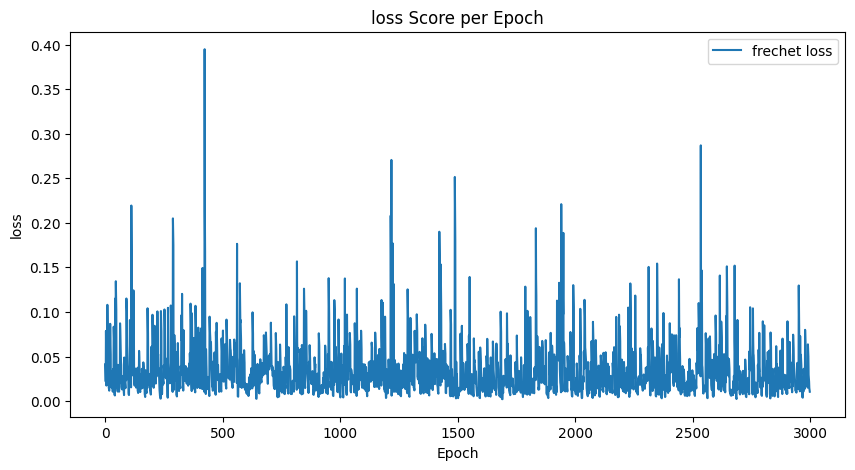

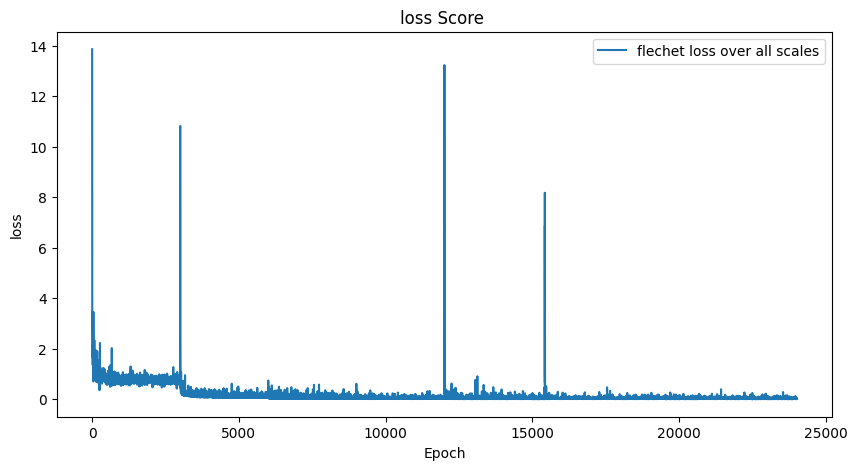

In [30]:

# Step 1: Get the command-line arguments or configuration settings
args = get_arguments()
opt = args

# Step 2: Set the name of the input image
opt.input_name = 'etretat.jpg'  # You can change this to the desired input image name

# Step 3: Finalize the configuration settings
opt = post_config(opt)

# Step 4: Initialize lists to store models, latent vectors, real images, and noise amplification factors
Gs = []         # List to store the generator networks for each scale
Zs = []         # List to store the latent vectors for each scale
reals = []      # List to store the real images for each scale
NoiseAmp = []   # List to store the noise amplification factors for each scale

# Step 5: Generate the directory path to save the trained models
dir2save = generate_dir2save(opt)

# Step 6: Check if the directory already exists
if os.path.exists(dir2save):
    print('Directory for Trained model already exists')  # If it exists, print a message
else:
    # If it does not exist, create the directory
    try:
        os.makedirs(dir2save)
    except OSError:
        pass  # If there's an error in creating the directory, just pass

# Step 7: Read and preprocess the input image
real = read_image(opt)

# Step 8: Adjust the scales of the image according to the configuration settings
adjust_scales2image(real, opt)


# Step 9: Train the model using the configurations and initialized lists
train(opt, Gs, Zs, reals, NoiseAmp)



In [32]:
!zip -r TrainedModels_Frechet_distance_loss.zip TrainedModels
from google.colab import files
files.download("TrainedModels_Frechet_distance_loss.zip")

  adding: TrainedModels/ (stored 0%)
  adding: TrainedModels/etretat/ (stored 0%)
  adding: TrainedModels/etretat/scale_factor=0.750000,alpha=10/ (stored 0%)
  adding: TrainedModels/etretat/scale_factor=0.750000,alpha=10/7/ (stored 0%)
  adding: TrainedModels/etretat/scale_factor=0.750000,alpha=10/7/netD.pth (deflated 9%)
  adding: TrainedModels/etretat/scale_factor=0.750000,alpha=10/7/G(z_opt).png (deflated 0%)
  adding: TrainedModels/etretat/scale_factor=0.750000,alpha=10/7/fake_sample.png (deflated 0%)
  adding: TrainedModels/etretat/scale_factor=0.750000,alpha=10/7/real_scale.png (deflated 0%)
  adding: TrainedModels/etretat/scale_factor=0.750000,alpha=10/7/z_opt.pth (deflated 100%)
  adding: TrainedModels/etretat/scale_factor=0.750000,alpha=10/7/netG.pth (deflated 8%)
  adding: TrainedModels/etretat/scale_factor=0.750000,alpha=10/reals.pth (deflated 34%)
  adding: TrainedModels/etretat/scale_factor=0.750000,alpha=10/0/ (stored 0%)
  adding: TrainedModels/etretat/scale_factor=0.750

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **2.2- Loss 2 : (Aligned) Nearest Neighbor patch Loss**

In [33]:
class NearestNeighborPatchLoss(nn.Module):

    def __init__(self, real_image, patch_size=11, stride=1, max_folds=20000):
        # real image : image tensor (1,3,h,w)
        super(NearestNeighborPatchLoss, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.patch_size = patch_size
        self.stride = stride
        self.unfold = nn.Unfold(kernel_size=self.patch_size, stride=self.stride)
        self.real_patches = (self.unfold(torch.squeeze(real_image)).T).to(self.device)
        self.max_folds = max_folds


    def forward(self, fake_image):
        # real image : image tensor (1,3,h,w)
        fake_patches = (self.unfold(torch.squeeze(fake_image)).T).to(self.device)

        if fake_patches.size()[0] > self.max_folds:
            batch_distances = torch.Tensor([0]).to(self.device)
            step = int(self.max_folds/2)
            for i in range(0, fake_patches.size()[0], step):
                batch_fake_patches = fake_patches[step*i:min((i+1)*step, fake_patches.size()[0]), :]
                distances = torch.cdist(batch_fake_patches, self.real_patches, p=2)
                min_distances, _ = distances.min(dim=1)
                batch_distances += min_distances.sum()
                del distances, min_distances

            return batch_distances / fake_patches.size()[0]
        else :
            distances = torch.cdist(self.real_patches, fake_patches, p=2)
            min_distances, _ = distances.min(dim=1)
            return min_distances.mean()



In [34]:
def update_generator_new_loss(netG, real, fake, nearest_loss, optimizerG, z_opt, z_prev, alpha, opt):
    netG.zero_grad()

    # Forward pass through discriminator
    errG = nearest_loss(fake)  # Calculate the generator loss
    errG.backward(retain_graph=True)  # Backpropagate the generator loss

    rec_loss = 0
    if alpha != 0:
        loss = nn.MSELoss()
        Z_opt = opt.noise_amp * z_opt+ z_prev
        rec_loss = alpha * loss(netG(Z_opt.detach(), z_prev.detach()), real)
        rec_loss.backward()  # Backpropagate the reconstruction loss
        rec_loss = rec_loss.detach()  # Detach to avoid inplace operation issues

    optimizerG.step()  # Update generator parameters

    return errG, rec_loss

In [35]:
class NearestNeighborPatchLoss_5(nn.Module):

    def __init__(self, real_image, patch_size=11, stride=1, max_folds=20000):
        # real image : image tensor (1,3,h,w)
        super(NearestNeighborPatchLoss_5, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.patch_size = patch_size
        self.stride = stride
        self.unfold = nn.Unfold(kernel_size=self.patch_size, stride=self.stride).to(self.device)
        self.real_patches = (self.unfold(torch.squeeze(real_image)).T).to(self.device)
        self.bn = nn.BatchNorm1d(self.real_patches.size(1)).to(self.device)
        self.real_patches = self.bn(self.real_patches).detach()
        self.max_folds = max_folds

    def forward(self, fake_image):
        # real image : image tensor (1,3,h,w)
        fake_patches = (self.unfold(torch.squeeze(fake_image)).T).to(self.device)
        fake_patches = self.bn(fake_patches)
        if fake_patches.size()[0] > self.max_folds:
            batch_distances = torch.Tensor([0]).to(self.device)
            step = int(self.max_folds/2)
            for i in range(0, fake_patches.size()[0], step):
                batch_fake_patches = fake_patches[step*i:min((i+1)*step, fake_patches.size()[0]), :]
                distances = torch.cdist(batch_fake_patches, self.real_patches, p=2)
                min_distances, _ = distances.min(dim=1)
                batch_distances += min_distances.sum()
                del distances, min_distances

            return batch_distances / fake_patches.size()[0]
        else :
            distances = torch.cdist(self.real_patches, fake_patches, p=2)
            min_distances, _ = distances.min(dim=1)
            return min_distances.mean()

### New training

In [36]:
def train_single_scale_new(netD, netG, reals, Gs, Zs, in_s, NoiseAmp, opt):
    torch.autograd.set_detect_anomaly(True)  # Enable anomaly detection for debugging
    real = reals[len(Gs)].float()  # Get the current real image at the current scale
    opt.nzx = real.shape[2]  # Set the size of the noise along x-dimension
    opt.nzy = real.shape[3]  # Set the size of the noise along y-dimension
    opt.receptive_field = opt.ker_size + ((opt.ker_size - 1) * (opt.num_layer - 1)) * opt.stride  # Calculate receptive field size
    pad_noise = int(((opt.ker_size - 1) * opt.num_layer) / 2)  # Calculate padding for noise
    pad_image = int(((opt.ker_size - 1) * opt.num_layer) / 2)  # Calculate padding for image

    # Zero-pad
    m_noise = nn.ZeroPad2d(int(pad_noise))  # Create padding layer for noise
    m_image = nn.ZeroPad2d(int(pad_image))  # Create padding layer for image

    # Circular-pad
    #m_noise = nn.CircularPad2d(int(pad_noise))  # Create circular padding layer for noise
    #m_image = nn.CircularPad2d(int(pad_image))  # Create circular padding layer for image

    # Symetric-pad
    #m_noise = nn.ReflectionPad2d(int(pad_noise))  # Create reflection padding layer for noise
    #m_image = nn.ReflectionPad2d(int(pad_image))  # Create reflection padding layer for image

    alpha = opt.alpha  # Set alpha parameter

    fixed_noise = generate_noise([opt.nc_z, opt.nzx, opt.nzy], device=opt.device).float()  # Generate fixed noise
    z_opt = torch.full(fixed_noise.shape, 0, device=opt.device).float()  # Initialize z_opt with zeros
    z_opt = m_noise(z_opt)  # Apply noise padding

    #optimizerD = optim.Adam(netD.parameters(), lr=opt.lr_d, betas=(opt.beta1, 0.999))  # Create optimizer for the discriminator
    optimizerG = optim.Adam(netG.parameters(), lr=opt.lr_g, betas=(opt.beta1, 0.999))  # Create optimizer for the generator
    #schedulerD = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizerD, milestones=[1600], gamma=opt.gamma)  # Learning rate scheduler for discriminator
    schedulerG = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizerG, milestones=[1600], gamma=opt.gamma)  # Learning rate scheduler for generator

#########################################################     change here for the non aligned loss  #######################################################################################################################################################################################

    # new criterion
    #nearest_loss = NearestNeighborPatchLoss(real, patch_size=11, stride=1)
    nearest_loss = NearestNeighborPatchLoss_5(real, patch_size=11, stride=1)

############################################################################################################################################################################################################################################################################################
    Loss_plot = []  # List to store SIFID scores

    for epoch in range(opt.niter):
        if not Gs:  # If there are no previous scales
            z_opt = generate_noise([1, opt.nzx, opt.nzy], device=opt.device).float()  # Generate new noise
            z_opt = m_noise(z_opt.expand(1, 3, opt.nzx, opt.nzy))  # Expand and pad the noise
            noise_ = generate_noise([1, opt.nzx, opt.nzy], device=opt.device).float()  # Generate another noise
            noise_ = m_noise(noise_.expand(1, 3, opt.nzx, opt.nzy))  # Expand and pad the noise
        else:
            noise_ = generate_noise([opt.nc_z, opt.nzx, opt.nzy], device=opt.device).float()  # Generate new noise for the current scale
            noise_ = m_noise(noise_)  # Pad the noise

        if epoch == 0:  # At the start of training
            if not Gs:  # If there are no previous scales
                prev = torch.full([1, opt.nc_z, opt.nzx, opt.nzy], 0, device=opt.device).float()  # Initialize prev with zeros
                in_s = prev  # Set in_s to prev
                prev = m_image(prev)  # Apply image padding
                z_prev = torch.full([1, opt.nc_z, opt.nzx, opt.nzy], 0, device=opt.device).float()  # Initialize z_prev with zeros
                z_prev = m_noise(z_prev)  # Apply noise padding
                opt.noise_amp = 1  # Set noise amplitude
            else:  # If there are previous scales
                prev = draw_concat(Gs, Zs, reals, NoiseAmp, in_s, 'rand', m_noise, m_image, opt).float()  # Draw concatenated image with random noise
                prev = m_image(prev)  # Apply image padding
                z_prev = draw_concat(Gs, Zs, reals, NoiseAmp, in_s, 'rec', m_noise, m_image, opt).float()  # Draw concatenated image with reconstruction noise
                criterion = nn.MSELoss()  # Define Mean Squared Error loss
                RMSE = torch.sqrt(criterion(real, z_prev))  # Calculate Root Mean Squared Error between real and z_prev
                opt.noise_amp = opt.noise_amp_init * RMSE  # Adjust noise amplitude based on RMSE
                z_prev = m_image(z_prev)  # Apply image padding
        else:
            prev = draw_concat(Gs, Zs, reals, NoiseAmp, in_s, 'rand', m_noise, m_image, opt).float()  # Draw concatenated image with random noise
            prev = m_image(prev)  # Apply image padding

        if not Gs:
            noise = noise_
        else:
            noise = opt.noise_amp * noise_ + prev  # Combine noise and previous image

        fake = netG(noise.detach(), prev.float())  # Generate fake image using the generator

        # Update discriminator
        #for j in range(opt.Dsteps):
        #    errD, D_x, D_G_z = update_discriminator(netD, real, fake, optimizerD, opt)  # Update discriminator

        # Update generator
        #for j in range(opt.Gsteps):
        fake = netG(noise.detach(), prev.float())  # Generate fake image using the generator
        errG, rec_loss = update_generator_new_loss(netG, real, fake, nearest_loss, optimizerG, z_opt, z_prev, alpha, opt)  # Update generator

        Loss_plot.append(errG.detach().item())

        if epoch % 25 == 0 or epoch == (opt.niter - 1):
            print('scale %d:[%d/%d]' % (len(Gs), epoch, opt.niter))  # Print progress
        """
        if epoch % 500 == 0 or epoch == (opt.niter - 1):
            plt.imsave('%s/fake_sample.png' % (opt.outf), convert_image_np(fake.detach()), vmin=0, vmax=1)  # Save fake image
            plt.imsave('%s/G(z_opt).png' % (opt.outf), convert_image_np(netG(z_opt.detach(), z_prev.float()).detach()), vmin=0, vmax=1)  # Save generator output for z_opt
            torch.save(z_opt, '%s/z_opt.pth' % (opt.outf))  # Save z_opt
        """
    plt.imsave('%s/G(z_opt).png' % (opt.outf), convert_image_np(netG(z_opt.detach(), z_prev.float()).detach()), vmin=0, vmax=1)
    plt.imsave('%s/fake_sample.png' % (opt.outf), convert_image_np(fake.detach()), vmin=0, vmax=1)
    # Display the real and fake images in the same row at the end of training each scale
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(convert_image_np(real), vmin=0, vmax=1)
    ax[0].set_title('Real Image')
    ax[0].axis('off')

    ax[1].imshow(convert_image_np(fake.detach()), vmin=0, vmax=1)
    ax[1].set_title('Fake Image')
    ax[1].axis('off')

    plt.show()

    # Plot SIFID scores

    plt.figure(figsize=(10, 5))
    plt.plot(Loss_plot, label='loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Score per Epoch')
    plt.legend()
    plt.show()
    plt.savefig('%s/Loss_scale_%d.png' % (opt.outf, len(Gs)))


    save_networks(netG, netD, z_opt, opt)  # Save the networks
    return z_opt, in_s, netG  # Return the optimal z, input scale, and generator


In [37]:
def train(opt, Gs, Zs, reals, NoiseAmp):
    # Read and preprocess the input image
    real_ = read_image(opt)
    in_s = 0  # Initialize the starting image
    scale_num = 0  # Initialize the scale level
    real = imresize(real_, opt.scale1, opt)  # Resize the input image to the first scale ## The input image will have max dim = 250 and will be resized accordingly
    reals = creat_reals_pyramid(real, reals, opt)  # Create a pyramid of resized images
    nfc_prev = 0  # Initialize the previous number of feature channels

    while scale_num < opt.stop_scale + 1:
        # Update the number of feature channels based on the scale level
        opt.nfc = min(opt.nfc_init * pow(2, math.floor(scale_num / 4)), 128)
        opt.min_nfc = min(opt.min_nfc_init * pow(2, math.floor(scale_num / 4)), 128)

        # Generate directory to save the models
        opt.out_ = generate_dir2save(opt)
        opt.outf = f'{opt.out_}/{scale_num}'
        os.makedirs(opt.outf, exist_ok=True)  # Create the directory if it doesn't exist

        # Save the real image at the current scale
        plt.imsave(f'{opt.outf}/real_scale.png', convert_image_np(reals[scale_num]), vmin=0, vmax=1)

        # Initialize the models for the current scale
        D_curr, G_curr = init_models(opt)
        if nfc_prev == opt.nfc:
            # Load pre-trained weights if the number of feature channels hasn't changed
            G_curr.load_state_dict(torch.load(f'{opt.out_}/{scale_num-1}/netG.pth'))
            D_curr.load_state_dict(torch.load(f'{opt.out_}/{scale_num-1}/netD.pth'))

        # Train the models for the current scale
        z_curr, in_s, G_curr = train_single_scale_new(D_curr, G_curr, reals, Gs, Zs, in_s, NoiseAmp, opt)

        # Set the models to evaluation mode and reset their gradients
        G_curr = reset_grads(G_curr, False)
        G_curr.eval()
        D_curr = reset_grads(D_curr, False)
        D_curr.eval()

        # Append the trained models and parameters to their respective lists
        Gs.append(G_curr)
        Zs.append(z_curr)
        NoiseAmp.append(opt.noise_amp)

        # Save the current state of the training process
        torch.save(Zs, f'{opt.out_}/Zs.pth')
        torch.save(Gs, f'{opt.out_}/Gs.pth')
        torch.save(reals, f'{opt.out_}/reals.pth')
        torch.save(NoiseAmp, f'{opt.out_}/NoiseAmp.pth')

        # Move to the next scale
        scale_num += 1
        nfc_prev = opt.nfc
        del D_curr, G_curr  # Free up memory

    return


### Defining hyperparameters

In [43]:
# @title
class DotDict(dict):
    """ Dictionary with dot notation access to attributes. """
    def __getattr__(self, attr):
        return self.get(attr)

    def __setattr__(self, attr, value):
        self[attr] = value

    def __delattr__(self, attr):
        del self[attr]


def get_arguments():
    args = DotDict()
    args.not_cuda = False
    args.netG = ''  #Path to a pre-trained generator network, if any. Default is an empty string.
    args.netD = ''  #Path to a pre-trained discriminator network, if any. Default is an empty string.
    args.manualSeed = None   #Seed for random number generation.
    args.nc_z = 3    #Number of channels in the noise input. Default is 3.
    args.nc_im = 3  #Number of channels in the input image. Default is 3.
    args.out = 'Output'   #Directory to save the output results.
    args.nfc = 32      #Number of feature channels in the first layer of the generator. Default is 32.
    args.min_nfc = 32   #Minimum number of feature channels in the generator. Default is 32.
    args.ker_size = 3  #Kernel size for the convolutional layers. Default is 3.
    args.num_layer = 5   #Number of layers in the generator and discriminator networks. Default is 5.
    args.stride = 1     #Stride for the convolutional layers. Default is 1.
    args.padd_size = 0    #Padding size for the convolutional layers. Default is 0.
    args.scale_factor = 0.75   #Scale factor for creating image pyramids. Default is 0.75.
    args.noise_amp = 0.1   #Amplitude of the noise added at each scale. Default is 0.1.
    args.min_size = 25   #Minimum size of the images in the pyramid. Default is 25.
    args.max_size = 250   #Maximum size of the images in the pyramid. Default is 250
    args.niter = 2000  #Number of iterations for training at each scale. Default is 10.
    args.gamma = 0.1   #Factor for learning rate decay. Default is 0.1.
    args.lr_g = 0.0005    #Learning rate for the generator. Default is 0.0005.
    args.lr_d = 0.0005    #Learning rate for the discriminator. Default is 0.0005.
    args.beta1 = 0.5    #Beta1 parameter for Adam optimizer. Default is 0.5.
    args.Gsteps = 3    #Number of steps to update the generator in each iteration. Default is 3.
    args.Dsteps = 3    #Number of steps to update the discriminator in each iteration. Default is 3.
    args.lambda_grad = 0.1    #Gradient penalty coefficient for WGAN-GP. Default is 0.1.
    args.alpha = 10     # Weight for the reconstruction loss. Default is 10
    args.input_dir = 'Input'  #Directory containing the input images.
    args.input_name = ''   #Name of the input image file.
    args.mode = 'train' #Mode of operation
    #args.plots = "Plots"  #Directory to save the plots.

    return args

def post_config(opt):
    """ adjusts some of the configuration parameters based on the initial settings and performs additional setup"""
    opt.device = torch.device("cpu" if opt.not_cuda or not torch.cuda.is_available() else "cuda")
    opt.niter_init = opt.niter
    opt.noise_amp_init = opt.noise_amp
    opt.nfc_init = opt.nfc
    opt.min_nfc_init = opt.min_nfc
    opt.scale_factor_init = opt.scale_factor
    opt.out_ = 'TrainedModels/%s/scale_factor=%f/' % (opt.input_name[:-4], opt.scale_factor)

    if opt.manualSeed is None:
        opt.manualSeed = random.randint(1, 10000)
    print("Random Seed: ", opt.manualSeed)
    random.seed(opt.manualSeed)
    torch.manual_seed(opt.manualSeed)
    if torch.cuda.is_available() and opt.not_cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")
    return opt

### Main
🚩 **NB**: You should have a file 'Input' in which there will be the input image and change its name in the variable 'opt.input_name' below

In [44]:
# free memory from cuda
torch.cuda.empty_cache()

In [45]:
# prompt: delete folder
!rm -rf /content/TrainedModels

Random Seed:  1065
scale 0:[0/2000]
scale 0:[25/2000]
scale 0:[50/2000]
scale 0:[75/2000]
scale 0:[100/2000]
scale 0:[125/2000]
scale 0:[150/2000]
scale 0:[175/2000]
scale 0:[200/2000]
scale 0:[225/2000]
scale 0:[250/2000]
scale 0:[275/2000]
scale 0:[300/2000]
scale 0:[325/2000]
scale 0:[350/2000]
scale 0:[375/2000]
scale 0:[400/2000]
scale 0:[425/2000]
scale 0:[450/2000]
scale 0:[475/2000]
scale 0:[500/2000]
scale 0:[525/2000]
scale 0:[550/2000]
scale 0:[575/2000]
scale 0:[600/2000]
scale 0:[625/2000]
scale 0:[650/2000]
scale 0:[675/2000]
scale 0:[700/2000]
scale 0:[725/2000]
scale 0:[750/2000]
scale 0:[775/2000]
scale 0:[800/2000]
scale 0:[825/2000]
scale 0:[850/2000]
scale 0:[875/2000]
scale 0:[900/2000]
scale 0:[925/2000]
scale 0:[950/2000]
scale 0:[975/2000]
scale 0:[1000/2000]
scale 0:[1025/2000]
scale 0:[1050/2000]
scale 0:[1075/2000]
scale 0:[1100/2000]
scale 0:[1125/2000]
scale 0:[1150/2000]
scale 0:[1175/2000]
scale 0:[1200/2000]
scale 0:[1225/2000]
scale 0:[1250/2000]
scale 

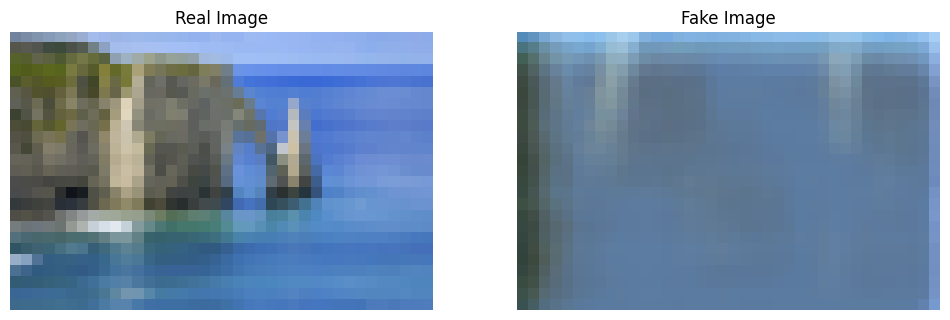

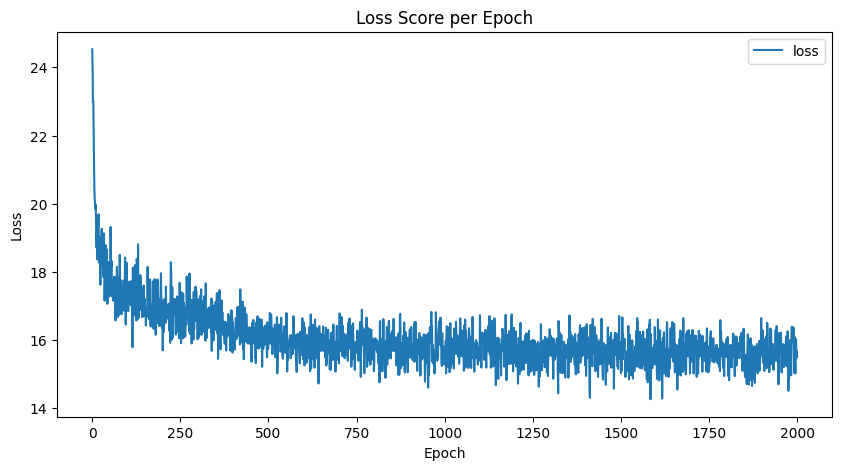

scale 1:[0/2000]
scale 1:[25/2000]
scale 1:[50/2000]
scale 1:[75/2000]
scale 1:[100/2000]
scale 1:[125/2000]
scale 1:[150/2000]
scale 1:[175/2000]
scale 1:[200/2000]
scale 1:[225/2000]
scale 1:[250/2000]
scale 1:[275/2000]
scale 1:[300/2000]
scale 1:[325/2000]
scale 1:[350/2000]
scale 1:[375/2000]
scale 1:[400/2000]
scale 1:[425/2000]
scale 1:[450/2000]
scale 1:[475/2000]
scale 1:[500/2000]
scale 1:[525/2000]
scale 1:[550/2000]
scale 1:[575/2000]
scale 1:[600/2000]
scale 1:[625/2000]
scale 1:[650/2000]
scale 1:[675/2000]
scale 1:[700/2000]
scale 1:[725/2000]
scale 1:[750/2000]
scale 1:[775/2000]
scale 1:[800/2000]
scale 1:[825/2000]
scale 1:[850/2000]
scale 1:[875/2000]
scale 1:[900/2000]
scale 1:[925/2000]
scale 1:[950/2000]
scale 1:[975/2000]
scale 1:[1000/2000]
scale 1:[1025/2000]
scale 1:[1050/2000]
scale 1:[1075/2000]
scale 1:[1100/2000]
scale 1:[1125/2000]
scale 1:[1150/2000]
scale 1:[1175/2000]
scale 1:[1200/2000]
scale 1:[1225/2000]
scale 1:[1250/2000]
scale 1:[1275/2000]
scale

<Figure size 640x480 with 0 Axes>

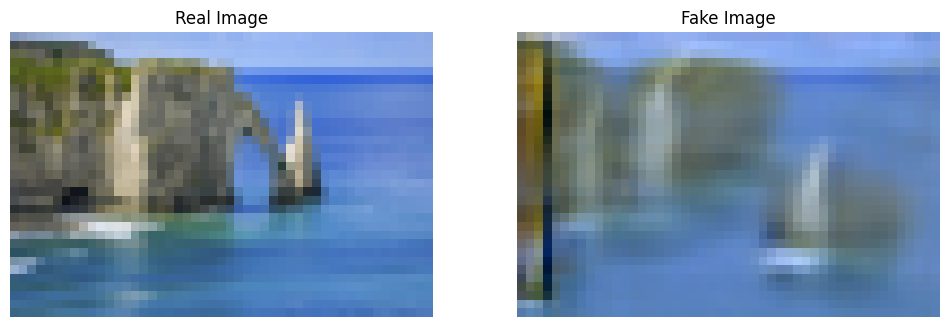

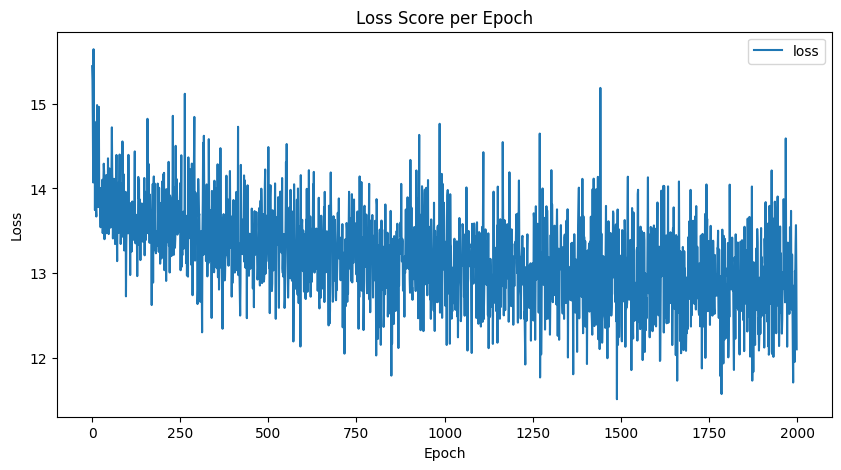

scale 2:[0/2000]
scale 2:[25/2000]
scale 2:[50/2000]
scale 2:[75/2000]
scale 2:[100/2000]
scale 2:[125/2000]
scale 2:[150/2000]
scale 2:[175/2000]
scale 2:[200/2000]
scale 2:[225/2000]
scale 2:[250/2000]
scale 2:[275/2000]
scale 2:[300/2000]
scale 2:[325/2000]
scale 2:[350/2000]
scale 2:[375/2000]
scale 2:[400/2000]
scale 2:[425/2000]
scale 2:[450/2000]
scale 2:[475/2000]
scale 2:[500/2000]
scale 2:[525/2000]
scale 2:[550/2000]
scale 2:[575/2000]
scale 2:[600/2000]
scale 2:[625/2000]
scale 2:[650/2000]
scale 2:[675/2000]
scale 2:[700/2000]
scale 2:[725/2000]
scale 2:[750/2000]
scale 2:[775/2000]
scale 2:[800/2000]
scale 2:[825/2000]
scale 2:[850/2000]
scale 2:[875/2000]
scale 2:[900/2000]
scale 2:[925/2000]
scale 2:[950/2000]
scale 2:[975/2000]
scale 2:[1000/2000]
scale 2:[1025/2000]
scale 2:[1050/2000]
scale 2:[1075/2000]
scale 2:[1100/2000]
scale 2:[1125/2000]
scale 2:[1150/2000]
scale 2:[1175/2000]
scale 2:[1200/2000]
scale 2:[1225/2000]
scale 2:[1250/2000]
scale 2:[1275/2000]
scale

<Figure size 640x480 with 0 Axes>

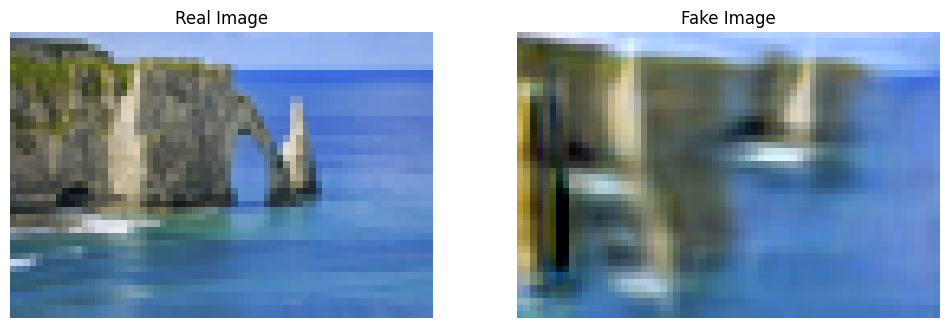

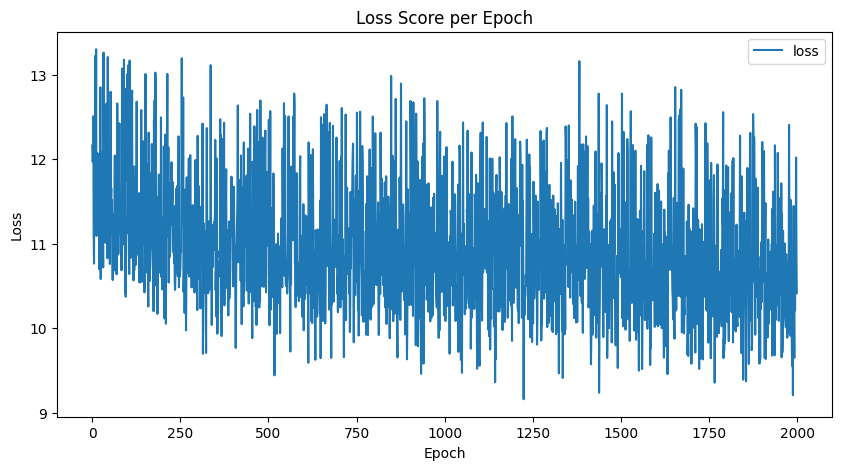

scale 3:[0/2000]
scale 3:[25/2000]
scale 3:[50/2000]
scale 3:[75/2000]
scale 3:[100/2000]
scale 3:[125/2000]
scale 3:[150/2000]
scale 3:[175/2000]
scale 3:[200/2000]
scale 3:[225/2000]
scale 3:[250/2000]
scale 3:[275/2000]
scale 3:[300/2000]
scale 3:[325/2000]
scale 3:[350/2000]
scale 3:[375/2000]
scale 3:[400/2000]
scale 3:[425/2000]
scale 3:[450/2000]
scale 3:[475/2000]
scale 3:[500/2000]
scale 3:[525/2000]
scale 3:[550/2000]
scale 3:[575/2000]
scale 3:[600/2000]
scale 3:[625/2000]
scale 3:[650/2000]
scale 3:[675/2000]
scale 3:[700/2000]
scale 3:[725/2000]
scale 3:[750/2000]
scale 3:[775/2000]
scale 3:[800/2000]
scale 3:[825/2000]
scale 3:[850/2000]
scale 3:[875/2000]
scale 3:[900/2000]
scale 3:[925/2000]
scale 3:[950/2000]
scale 3:[975/2000]
scale 3:[1000/2000]
scale 3:[1025/2000]
scale 3:[1050/2000]
scale 3:[1075/2000]
scale 3:[1100/2000]
scale 3:[1125/2000]
scale 3:[1150/2000]
scale 3:[1175/2000]
scale 3:[1200/2000]
scale 3:[1225/2000]
scale 3:[1250/2000]
scale 3:[1275/2000]
scale

<Figure size 640x480 with 0 Axes>

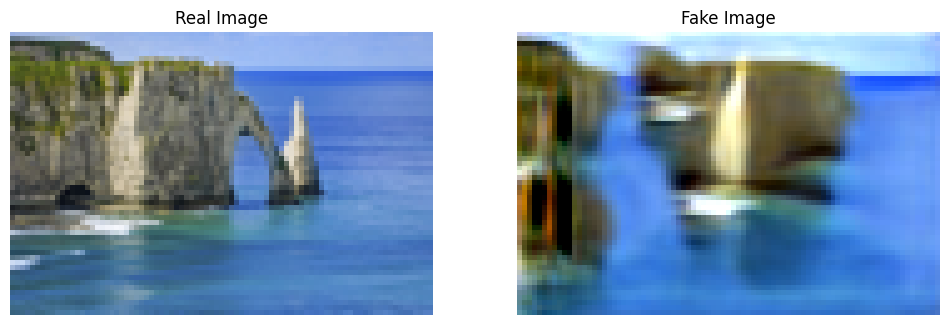

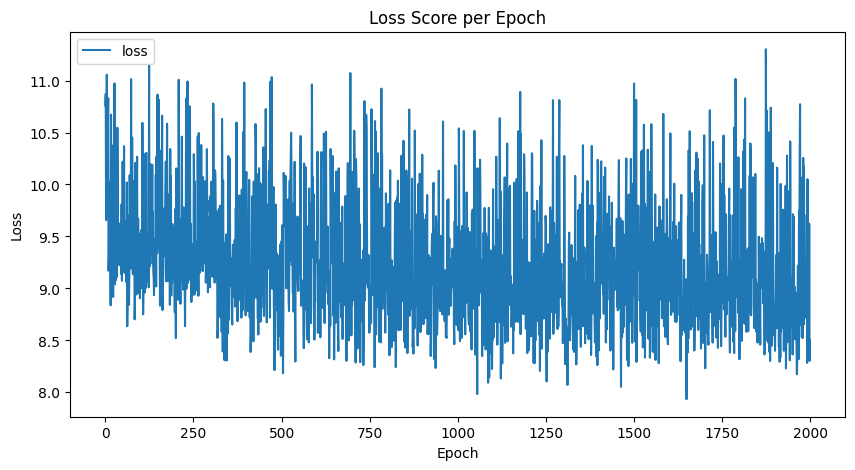

scale 4:[0/2000]
scale 4:[25/2000]
scale 4:[50/2000]
scale 4:[75/2000]
scale 4:[100/2000]
scale 4:[125/2000]
scale 4:[150/2000]
scale 4:[175/2000]
scale 4:[200/2000]
scale 4:[225/2000]
scale 4:[250/2000]
scale 4:[275/2000]
scale 4:[300/2000]
scale 4:[325/2000]
scale 4:[350/2000]
scale 4:[375/2000]
scale 4:[400/2000]
scale 4:[425/2000]
scale 4:[450/2000]
scale 4:[475/2000]
scale 4:[500/2000]
scale 4:[525/2000]
scale 4:[550/2000]
scale 4:[575/2000]
scale 4:[600/2000]
scale 4:[625/2000]
scale 4:[650/2000]
scale 4:[675/2000]
scale 4:[700/2000]
scale 4:[725/2000]
scale 4:[750/2000]
scale 4:[775/2000]
scale 4:[800/2000]
scale 4:[825/2000]
scale 4:[850/2000]
scale 4:[875/2000]
scale 4:[900/2000]
scale 4:[925/2000]
scale 4:[950/2000]
scale 4:[975/2000]
scale 4:[1000/2000]
scale 4:[1025/2000]
scale 4:[1050/2000]
scale 4:[1075/2000]
scale 4:[1100/2000]
scale 4:[1125/2000]
scale 4:[1150/2000]
scale 4:[1175/2000]
scale 4:[1200/2000]
scale 4:[1225/2000]
scale 4:[1250/2000]
scale 4:[1275/2000]
scale

<Figure size 640x480 with 0 Axes>

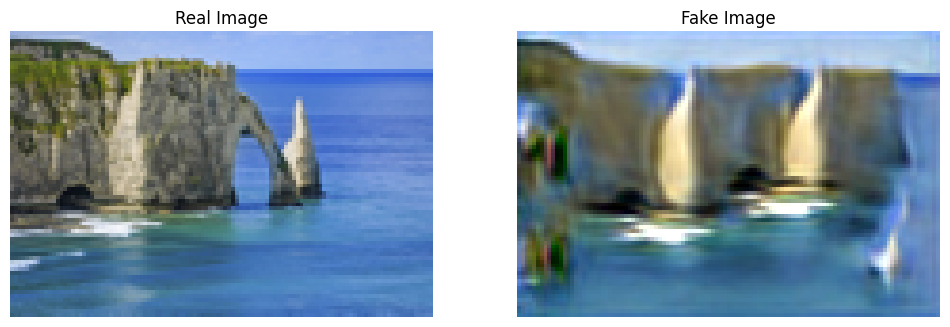

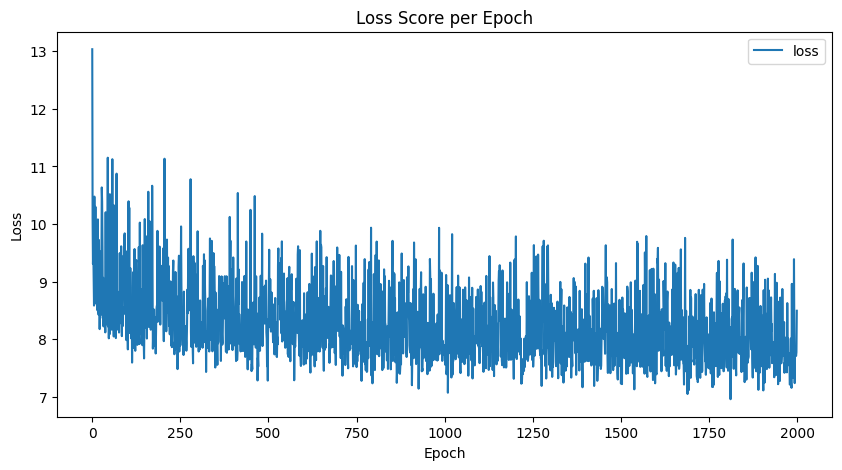

scale 5:[0/2000]
scale 5:[25/2000]
scale 5:[50/2000]
scale 5:[75/2000]
scale 5:[100/2000]
scale 5:[125/2000]
scale 5:[150/2000]
scale 5:[175/2000]
scale 5:[200/2000]
scale 5:[225/2000]
scale 5:[250/2000]
scale 5:[275/2000]
scale 5:[300/2000]
scale 5:[325/2000]
scale 5:[350/2000]
scale 5:[375/2000]
scale 5:[400/2000]
scale 5:[425/2000]
scale 5:[450/2000]
scale 5:[475/2000]
scale 5:[500/2000]
scale 5:[525/2000]
scale 5:[550/2000]
scale 5:[575/2000]
scale 5:[600/2000]
scale 5:[625/2000]
scale 5:[650/2000]
scale 5:[675/2000]
scale 5:[700/2000]
scale 5:[725/2000]
scale 5:[750/2000]
scale 5:[775/2000]
scale 5:[800/2000]
scale 5:[825/2000]
scale 5:[850/2000]
scale 5:[875/2000]
scale 5:[900/2000]
scale 5:[925/2000]
scale 5:[950/2000]
scale 5:[975/2000]
scale 5:[1000/2000]
scale 5:[1025/2000]
scale 5:[1050/2000]
scale 5:[1075/2000]
scale 5:[1100/2000]
scale 5:[1125/2000]
scale 5:[1150/2000]
scale 5:[1175/2000]
scale 5:[1200/2000]
scale 5:[1225/2000]
scale 5:[1250/2000]
scale 5:[1275/2000]
scale

<Figure size 640x480 with 0 Axes>

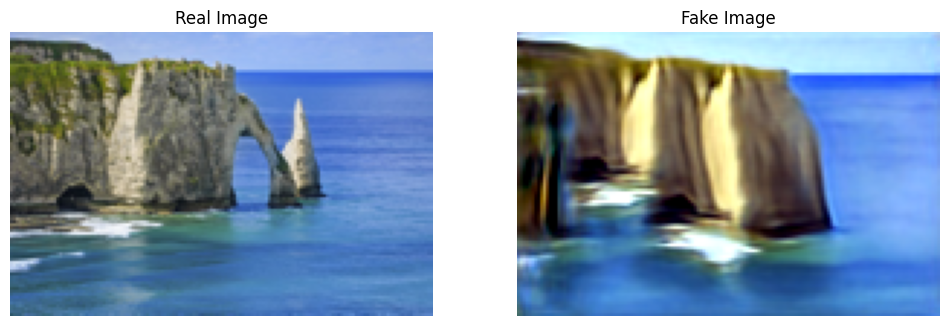

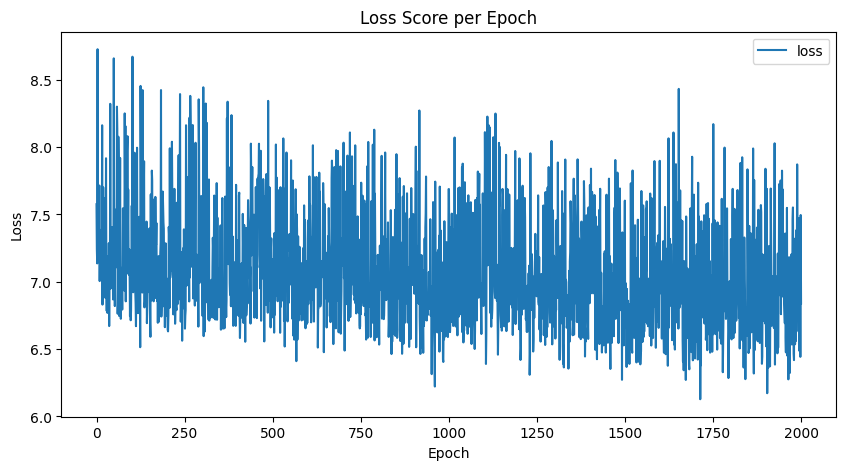

scale 6:[0/2000]
scale 6:[25/2000]
scale 6:[50/2000]
scale 6:[75/2000]
scale 6:[100/2000]
scale 6:[125/2000]
scale 6:[150/2000]
scale 6:[175/2000]
scale 6:[200/2000]
scale 6:[225/2000]
scale 6:[250/2000]
scale 6:[275/2000]
scale 6:[300/2000]
scale 6:[325/2000]
scale 6:[350/2000]
scale 6:[375/2000]
scale 6:[400/2000]
scale 6:[425/2000]
scale 6:[450/2000]
scale 6:[475/2000]
scale 6:[500/2000]
scale 6:[525/2000]
scale 6:[550/2000]
scale 6:[575/2000]
scale 6:[600/2000]
scale 6:[625/2000]
scale 6:[650/2000]
scale 6:[675/2000]
scale 6:[700/2000]
scale 6:[725/2000]
scale 6:[750/2000]
scale 6:[775/2000]
scale 6:[800/2000]
scale 6:[825/2000]
scale 6:[850/2000]
scale 6:[875/2000]
scale 6:[900/2000]
scale 6:[925/2000]
scale 6:[950/2000]
scale 6:[975/2000]
scale 6:[1000/2000]
scale 6:[1025/2000]
scale 6:[1050/2000]
scale 6:[1075/2000]
scale 6:[1100/2000]
scale 6:[1125/2000]
scale 6:[1150/2000]
scale 6:[1175/2000]
scale 6:[1200/2000]
scale 6:[1225/2000]
scale 6:[1250/2000]
scale 6:[1275/2000]
scale

<Figure size 640x480 with 0 Axes>

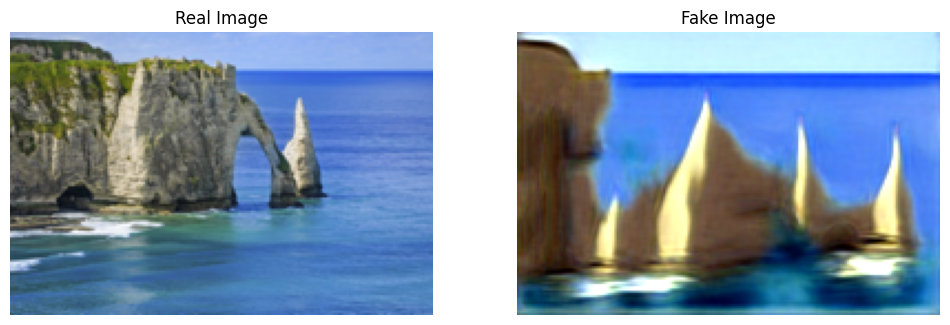

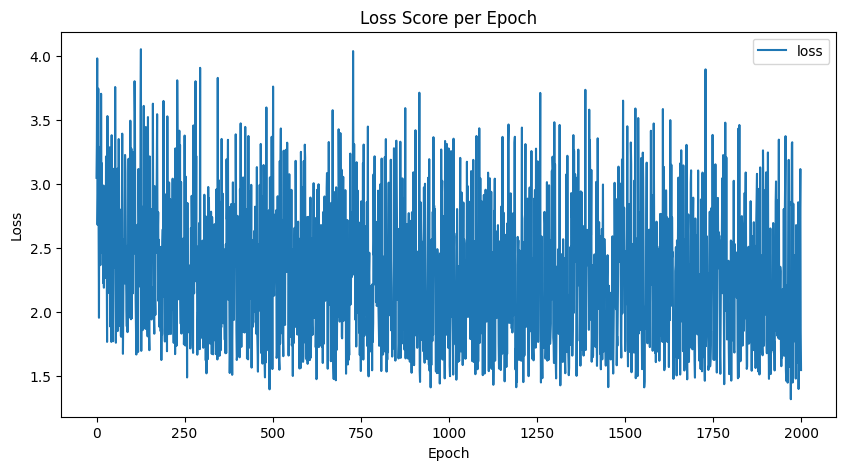

scale 7:[0/2000]
scale 7:[25/2000]
scale 7:[50/2000]
scale 7:[75/2000]
scale 7:[100/2000]
scale 7:[125/2000]
scale 7:[150/2000]
scale 7:[175/2000]
scale 7:[200/2000]
scale 7:[225/2000]
scale 7:[250/2000]
scale 7:[275/2000]
scale 7:[300/2000]
scale 7:[325/2000]
scale 7:[350/2000]
scale 7:[375/2000]
scale 7:[400/2000]
scale 7:[425/2000]
scale 7:[450/2000]
scale 7:[475/2000]
scale 7:[500/2000]
scale 7:[525/2000]
scale 7:[550/2000]
scale 7:[575/2000]
scale 7:[600/2000]
scale 7:[625/2000]
scale 7:[650/2000]
scale 7:[675/2000]
scale 7:[700/2000]
scale 7:[725/2000]
scale 7:[750/2000]
scale 7:[775/2000]
scale 7:[800/2000]
scale 7:[825/2000]
scale 7:[850/2000]
scale 7:[875/2000]
scale 7:[900/2000]
scale 7:[925/2000]
scale 7:[950/2000]
scale 7:[975/2000]
scale 7:[1000/2000]
scale 7:[1025/2000]
scale 7:[1050/2000]
scale 7:[1075/2000]
scale 7:[1100/2000]
scale 7:[1125/2000]
scale 7:[1150/2000]
scale 7:[1175/2000]
scale 7:[1200/2000]
scale 7:[1225/2000]
scale 7:[1250/2000]
scale 7:[1275/2000]
scale

<Figure size 640x480 with 0 Axes>

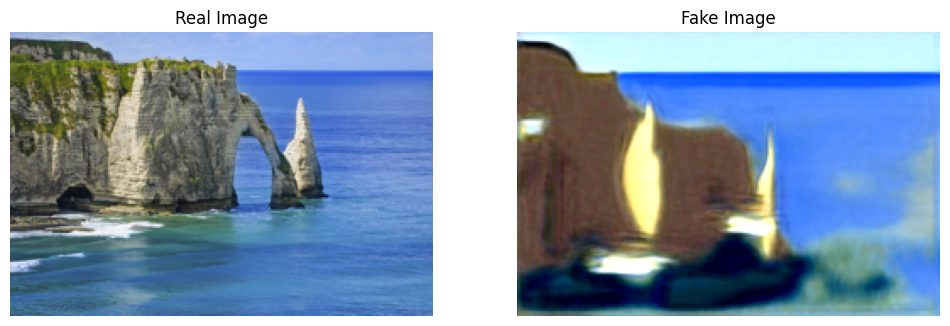

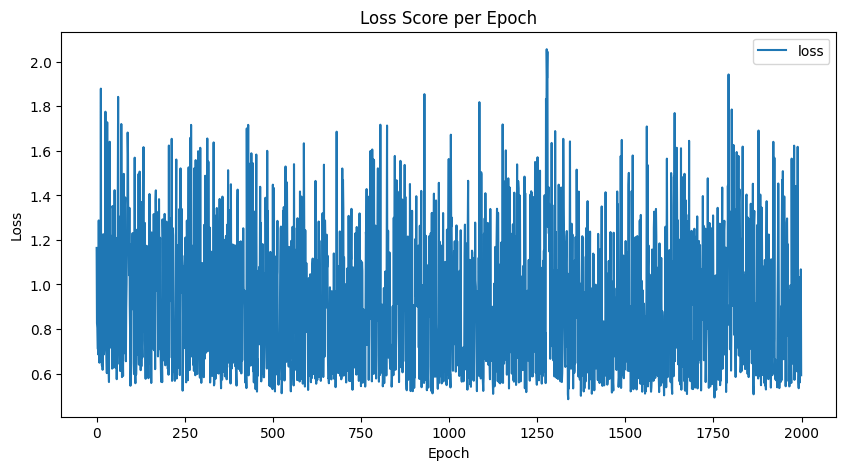

<Figure size 640x480 with 0 Axes>

In [46]:

# Step 1: Get the command-line arguments or configuration settings
args = get_arguments()
opt = args

# Step 2: Set the name of the input image
opt.input_name = 'etretat.jpg'  # You can change this to the desired input image name

# Step 3: Finalize the configuration settings
opt = post_config(opt)

# Step 4: Initialize lists to store models, latent vectors, real images, and noise amplification factors
Gs = []         # List to store the generator networks for each scale
Zs = []         # List to store the latent vectors for each scale
reals = []      # List to store the real images for each scale
NoiseAmp = []   # List to store the noise amplification factors for each scale

# Step 5: Generate the directory path to save the trained models
dir2save = generate_dir2save(opt)

# Step 6: Check if the directory already exists
if os.path.exists(dir2save):
    print('Directory for Trained model already exists')  # If it exists, print a message
else:
    # If it does not exist, create the directory
    try:
        os.makedirs(dir2save)
    except OSError:
        pass  # If there's an error in creating the directory, just pass



# Step 7: Read and preprocess the input image
real = read_image(opt)

# Step 8: Adjust the scales of the image according to the configuration settings
adjust_scales2image(real, opt)


# Step 9: Train the model using the configurations and initialized lists
train(opt, Gs, Zs, reals, NoiseAmp)



In [47]:
!zip -r TrainedModels_Frechet_distance_loss.zip TrainedModels
from google.colab import files
files.download("TrainedModels_Frechet_distance_loss.zip")

updating: TrainedModels/ (stored 0%)
updating: TrainedModels/etretat/ (stored 0%)
updating: TrainedModels/etretat/scale_factor=0.750000,alpha=10/ (stored 0%)
updating: TrainedModels/etretat/scale_factor=0.750000,alpha=10/7/ (stored 0%)
updating: TrainedModels/etretat/scale_factor=0.750000,alpha=10/7/netD.pth (deflated 9%)
updating: TrainedModels/etretat/scale_factor=0.750000,alpha=10/7/G(z_opt).png (deflated 0%)
updating: TrainedModels/etretat/scale_factor=0.750000,alpha=10/7/Loss_scale_7.png (deflated 90%)
updating: TrainedModels/etretat/scale_factor=0.750000,alpha=10/7/fake_sample.png (deflated 0%)
updating: TrainedModels/etretat/scale_factor=0.750000,alpha=10/7/real_scale.png (deflated 0%)
updating: TrainedModels/etretat/scale_factor=0.750000,alpha=10/7/z_opt.pth (deflated 100%)
updating: TrainedModels/etretat/scale_factor=0.750000,alpha=10/7/netG.pth (deflated 8%)
updating: TrainedModels/etretat/scale_factor=0.750000,alpha=10/reals.pth (deflated 34%)
updating: TrainedModels/etretat

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>